# 2022 MLB All-Star Classifier

- Predictor variables are taken using MLB data from 2010 - 2021 (*Data taken courtesy of Baseball-reference.com*)
    - Data from 2020 has been ommited, COVID-19 season was shortened to 60 games and no All-Star Game (ASG) was held.
    - Non-qualfying hitters have been ommited, qualifiers must have 3.1 PA/G
    - Positional variable will use the position most often played, Outfield(OF) is inclusive and doesn't indicate specific OF position.

- The MLB All-Star teams are selected in the following manner:
    1. Starters are selected through Fan Voting (Through 2021, this meant 8 starters in the National League (NL) and 9 starters in the American League (AL).  In 2022, the Designated Hitter (DH) has been introduced into the NL and there will be 9 starters selected for each league).
    2. Players vote selects 8 position players for each league to serve as ASG reserves.
    3. Commisioners office selects final reserves, estimated between 2-4 position players.  (*Prior to 2017 the final reserves were selected by the ASG Manager of each team, the Manager is a representative of each team that made the World Series the previous season for that given League*)
    * Note - One player must be selected from each MLB team, this is done to make sure every fanbase has representation from their team


- In creating this classification model, one mustunderstand limitations due to these selection processes and the inherent biases.
    - Fan Voting is the least reliable selection process as fans are incentivized to select players from their favorite team and/or the most popular players in the league.
    - Players Voting and Commisioners selections are more reliable in awarding spots based on statistical performance, but biases may still exist as some players may be selected due to their own reputation and/or career achievements.
    - Prior to 2017, Manager selections came with inherent bias to select "their own guys" and spots given as a reward and celebration of that team's success the previous season.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%reload_ext nb_black
pd.set_option("display.max_columns", None)
import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [2]:
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

<IPython.core.display.Javascript object>

In [3]:
from sklearn import metrics
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    plot_confusion_matrix,
    make_scorer,
)

<IPython.core.display.Javascript object>

## Load Dataset

In [4]:
data = pd.read_excel("C:/Users/Josh/Desktop/MLB_Batting_2010_2021.xlsx")
df = data.copy()
df.head()

,Name,Year,Age,Tm,Lg,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,BA,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB,Pos Summary,ASG
0,Josh Rojas*\rojasjo01,2021,27,ARI,NL,139,550,484,69,128,32,3,11,44,9,4,58,137,0.264,0.341,0.411,0.752,104,199,7,0,1,3,1,4697H5,0
1,Pavin Smith*\smithpa04,2021,25,ARI,NL,145,545,498,68,133,27,4,11,49,1,0,42,106,0.267,0.328,0.404,0.732,98,201,11,4,0,1,1,398H7,0
2,David Peralta*\peralda01,2021,33,ARI,NL,150,538,487,57,126,30,8,8,63,2,1,46,92,0.259,0.325,0.402,0.728,97,196,9,3,0,2,3,*7H/D1,0
3,Freddie Freeman*\freemfr01,2021,31,ATL,NL,159,695,600,120,180,25,2,31,83,8,3,85,107,0.300,0.393,0.503,0.896,133,302,11,8,0,2,15,*3,1
4,Austin Riley\rileyau01,2021,24,ATL,NL,160,662,590,91,179,33,1,33,107,0,1,52,168,0.303,0.367,0.531,0.898,132,313,11,12,0,8,2,*53/H9,0


<IPython.core.display.Javascript object>

In [5]:
df.shape

(1567, 31)

<IPython.core.display.Javascript object>

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         1567 non-null   object 
 1   Year         1567 non-null   int64  
 2   Age          1567 non-null   int64  
 3   Tm           1567 non-null   object 
 4   Lg           1567 non-null   object 
 5   G            1567 non-null   int64  
 6   PA           1567 non-null   int64  
 7   AB           1567 non-null   int64  
 8   R            1567 non-null   int64  
 9   H            1567 non-null   int64  
 10  2B           1567 non-null   int64  
 11  3B           1567 non-null   int64  
 12  HR           1567 non-null   int64  
 13  RBI          1567 non-null   int64  
 14  SB           1567 non-null   int64  
 15  CS           1567 non-null   int64  
 16  BB           1567 non-null   int64  
 17  SO           1567 non-null   int64  
 18  BA           1567 non-null   float64
 19  OBP   

<IPython.core.display.Javascript object>

### Formatting Dataset

In [7]:
# each name has an identifier and is separated by a backslash, this will be split and identifier into a new column
player_name = df["Name"]
df[["Name", "Identifier"]] = player_name.str.split("\\", n=1, expand=True)

<IPython.core.display.Javascript object>

In [8]:
# an asterisk after the name indicates a left-handed batter, this will be interpreted into a new column with a boolean
lh = "*"
df["left_hitter"] = df["Name"].str.lower().str.endswith(lh)

<IPython.core.display.Javascript object>

In [9]:
# a hashtag after the name indicates a switch-hitter, this will be interpreted in a new column with a boolean
sh = "#"
df["switch_hitter"] = df["Name"].str.lower().str.endswith(sh)

<IPython.core.display.Javascript object>

In [10]:
# if a batter isn't left-handed or a switch-hitter they must be right-handed, create a new column with boolean
df["right_hitter"] = (df["left_hitter"] == False) & (df["switch_hitter"] == False)

<IPython.core.display.Javascript object>

In [11]:
# asterisks and hashtags will be dropped from name
df["Name"] = df["Name"].str.replace("*", "", regex=True)
df["Name"] = df["Name"].str.replace("#", "", regex=True)

<IPython.core.display.Javascript object>

In [12]:
# position summary starting with asterisk means player was at position for 2/3rds of team games, this will be dropped
df["Pos Summary"] = df["Pos Summary"].str.replace("*", "", regex=True)

<IPython.core.display.Javascript object>

In [13]:
df.head(10)

,Name,Year,Age,Tm,Lg,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,BA,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB,Pos Summary,ASG,Identifier,left_hitter,switch_hitter,right_hitter
0,Josh Rojas,2021,27,ARI,NL,139,550,484,69,128,32,3,11,44,9,4,58,137,0.264,0.341,0.411,0.752,104,199,7,0,1,3,1,4697H5,0,rojasjo01,True,False,False
1,Pavin Smith,2021,25,ARI,NL,145,545,498,68,133,27,4,11,49,1,0,42,106,0.267,0.328,0.404,0.732,98,201,11,4,0,1,1,398H7,0,smithpa04,True,False,False
2,David Peralta,2021,33,ARI,NL,150,538,487,57,126,30,8,8,63,2,1,46,92,0.259,0.325,0.402,0.728,97,196,9,3,0,2,3,7H/D1,0,peralda01,True,False,False
3,Freddie Freeman,2021,31,ATL,NL,159,695,600,120,180,25,2,31,83,8,3,85,107,0.300,0.393,0.503,0.896,133,302,11,8,0,2,15,3,1,freemfr01,True,False,False
4,Austin Riley,2021,24,ATL,NL,160,662,590,91,179,33,1,33,107,0,1,52,168,0.303,0.367,0.531,0.898,132,313,11,12,0,8,2,53/H9,0,rileyau01,False,False,True
5,Ozzie Albies,2021,24,ATL,NL,156,686,629,103,163,40,7,30,106,20,4,47,128,0.259,0.310,0.488,0.799,105,307,4,3,0,7,2,4,1,albieoz01,False,True,False
6,Dansby Swanson,2021,27,ATL,NL,160,653,588,78,146,33,2,27,88,9,3,52,167,0.248,0.311,0.449,0.760,97,264,7,5,1,7,4,6/H,0,swansda01,False,False,True
7,Cedric Mullins,2021,26,BAL,AL,159,675,602,91,175,37,5,30,59,30,8,59,125,0.291,0.360,0.518,0.878,137,312,2,8,1,4,3,8/HD,1,mullice01,True,False,False
8,Ryan Mountcastle,2021,24,BAL,AL,144,586,534,77,136,23,1,33,89,4,3,41,161,0.255,0.309,0.487,0.796,114,260,12,4,0,7,2,3D7/H,0,mountry01,False,False,True
9,Austin Hays,2021,25,BAL,AL,131,529,488,73,125,26,4,22,71,4,3,28,107,0.256,0.308,0.461,0.769,107,225,9,9,3,1,0,79/H8,0,haysau01,False,False,True


<IPython.core.display.Javascript object>

In [14]:
# creating new column which will highlight the position the player appeared at most commonly
df["main_position"] = df["Pos Summary"].str[0]

<IPython.core.display.Javascript object>

In [15]:
# Fixing the formatting of players names which have accents, these were not properly interpreted in loading dataset
df["Name"] = df["Name"].str.replace("JosÃ© Abreu", "Jose Abreu", regex=True)
df["Name"] = df["Name"].str.replace("Yandy DÃaz", "Yandy Diaz", regex=True)
df["Name"] = df["Name"].str.replace("Adolis GarcÃa", "Adolis Garcia", regex=True)
df["Name"] = df["Name"].str.replace("Yordan Ãlvarez", "Yordan Alvarez", regex=True)
df["Name"] = df["Name"].str.replace("JosÃ© Iglesias", "Jose Iglesias", regex=True)
df["Name"] = df["Name"].str.replace("Eloy JimÃ©nez", "Eloy Jimenez", regex=True)
df["Name"] = df["Name"].str.replace("Robinson CanÃ³", "Robinson Cano", regex=True)
df["Name"] = df["Name"].str.replace("Yoenis CÃ©spedes", "Yoenis Cespedes", regex=True)
df["Name"] = df["Name"].str.replace("Alexei RamÃ­rez", "Alexei Ramirez", regex=True)
df["Name"] = df["Name"].str.replace("DayÃ¡n Viciedo", "Dayan Viciedo", regex=True)
df["Name"] = df["Name"].str.replace("Leonys MartÃ­n", "Leonys Martin", regex=True)

<IPython.core.display.Javascript object>

In [16]:
# dropping columns pos summary and identifier
df.drop(["Pos Summary", "Identifier"], axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [17]:
# switcing left_hitter and switch_hitter to integer columns, changes results to 0 & 1
df["left_hitter"] = df["left_hitter"].astype(int)
df["switch_hitter"] = df["switch_hitter"].astype(int)
df["right_hitter"] = df["right_hitter"].astype(int)

<IPython.core.display.Javascript object>

In [18]:
# renaming positions for clarity
df["main_position"] = df["main_position"].map(
    {
        "D": "DH",
        "2": "C",
        "3": "1B",
        "4": "2B",
        "5": "3B",
        "6": "SS",
        "7": "OF",
        "8": "OF",
        "9": "OF",
    }
)

<IPython.core.display.Javascript object>

In [19]:
df.sample(10)

,Name,Year,Age,Tm,Lg,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,BA,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB,ASG,left_hitter,switch_hitter,right_hitter,main_position
1450,Jay Bruce,2010,23,CIN,NL,148,573,509,80,143,23,5,25,70,5,4,58,136,0.281,0.353,0.493,0.846,124,251,12,1,0,5,5,0,1,0,0,OF
498,Khris Davis,2017,29,OAK,AL,153,652,566,91,140,28,1,43,110,4,0,73,195,0.247,0.336,0.528,0.864,131,299,20,6,0,7,1,0,0,0,1,OF
943,Neil Walker,2014,28,PIT,NL,137,571,512,74,139,25,3,23,76,2,2,45,88,0.271,0.342,0.467,0.809,126,239,12,11,1,2,2,0,0,1,0,2B
1100,Evan Longoria,2013,27,TBR,AL,160,693,614,91,165,39,3,32,88,1,0,70,162,0.269,0.343,0.498,0.842,133,306,16,3,0,6,10,0,0,0,1,3B
696,Jayson Werth,2016,37,WSN,NL,143,606,525,84,128,28,0,21,69,5,1,71,139,0.244,0.335,0.417,0.752,97,219,17,4,0,6,0,0,0,0,1,OF
606,Kendrys Morales,2016,33,KCR,AL,154,618,558,65,147,24,0,30,93,0,0,48,120,0.263,0.327,0.468,0.795,110,261,20,7,0,5,2,0,0,1,0,DH
401,Jonathan Villar,2018,27,TOT,MLB,141,515,466,54,121,14,1,14,46,35,5,41,138,0.260,0.325,0.384,0.709,93,179,13,5,1,2,0,0,0,1,0,2B
338,Christian Yelich,2018,26,MIL,NL,147,651,574,118,187,34,7,36,110,22,4,68,135,0.326,0.402,0.598,1.000,164,343,14,7,0,2,2,1,1,0,0,OF
1209,Nick Swisher,2012,31,NYY,AL,148,624,537,75,146,36,0,24,93,2,3,77,141,0.272,0.364,0.473,0.837,125,254,9,4,1,5,2,0,0,1,0,OF
1520,Adrian Gonzalez,2010,28,SDP,NL,160,693,591,87,176,33,0,31,101,0,0,93,114,0.298,0.393,0.511,0.904,152,302,15,2,2,4,35,1,1,0,0,1B


<IPython.core.display.Javascript object>

In [20]:
ops_rank = df.copy()
ops_rank.drop(
    [
        "left_hitter",
        "switch_hitter",
        "right_hitter",
        "CS",
        "SH",
        "SF",
        "GDP",
        "TB",
        "HBP",
    ],
    axis=1,
    inplace=True,
)
ops_rank.sort_values(by=["OPS+"], inplace=True, ascending=False)

<IPython.core.display.Javascript object>

In [21]:
ops_rank.head(10)

,Name,Year,Age,Tm,Lg,G,PA,AB,R,H,2B,3B,HR,RBI,SB,BB,SO,BA,OBP,SLG,OPS,OPS+,IBB,ASG,main_position
835,Bryce Harper,2015,22,WSN,NL,153,654,521,118,172,38,1,42,99,6,124,131,0.330,0.460,0.649,1.109,198,15,1,OF
325,Mike Trout,2018,26,LAA,AL,140,608,471,101,147,24,4,39,79,24,122,124,0.312,0.460,0.628,1.088,198,25,1,OF
1031,Miguel Cabrera,2013,30,DET,AL,148,652,555,103,193,26,1,44,137,3,90,94,0.348,0.442,0.636,1.078,190,19,1,3B
280,Mookie Betts,2018,25,BOS,AL,136,614,520,129,180,47,5,32,80,30,81,91,0.346,0.438,0.640,1.078,186,8,1,OF
467,Mike Trout,2017,25,LAA,AL,114,507,402,92,123,25,3,33,72,22,94,90,0.306,0.442,0.629,1.071,186,15,1,OF
1397,Jose Bautista,2011,30,TOR,AL,149,655,513,105,155,24,2,43,103,9,132,111,0.302,0.447,0.608,1.056,182,24,1,OF
186,Mike Trout,2019,27,LAA,AL,134,600,470,110,137,27,2,45,104,11,110,120,0.291,0.438,0.645,1.083,182,14,1,OF
77,Bryce Harper,2021,28,PHI,NL,141,599,488,101,151,42,1,35,84,13,100,134,0.309,0.429,0.615,1.044,181,14,0,OF
1314,Miguel Cabrera,2011,28,DET,AL,161,688,572,111,197,48,0,30,105,2,108,89,0.344,0.448,0.586,1.033,179,22,1,1B
198,Christian Yelich,2019,27,MIL,NL,130,580,489,100,161,29,3,44,97,30,80,118,0.329,0.429,0.671,1.100,179,16,1,OF


<IPython.core.display.Javascript object>

In [22]:
ops_rank.tail(10)

,Name,Year,Age,Tm,Lg,G,PA,AB,R,H,2B,3B,HR,RBI,SB,BB,SO,BA,OBP,SLG,OPS,OPS+,IBB,ASG,main_position
1303,Alex Rios,2011,30,CHW,AL,145,570,537,64,122,22,2,13,44,11,27,68,0.227,0.265,0.348,0.613,63,4,0,OF
1160,Drew Stubbs,2012,27,CIN,NL,136,544,493,75,105,13,2,14,40,30,42,166,0.213,0.277,0.333,0.610,63,0,0,OF
867,Zack Cozart,2014,28,CIN,NL,147,543,506,48,112,18,5,4,38,7,25,79,0.221,0.268,0.300,0.568,60,3,0,SS
1011,Darwin Barney,2013,27,CHC,NL,141,555,501,49,104,25,1,7,41,4,36,64,0.208,0.266,0.303,0.569,57,5,0,2B
702,Chris Owings,2015,23,ARI,NL,147,552,515,59,117,27,5,4,43,16,26,144,0.227,0.264,0.322,0.587,57,3,0,2B
1053,Adeiny Hechavarria,2013,24,MIA,NL,148,578,543,30,123,14,8,3,42,11,30,96,0.227,0.267,0.298,0.565,56,1,0,SS
82,Kevin Newman,2021,27,PIT,NL,148,554,517,50,117,22,3,5,39,6,27,41,0.226,0.265,0.309,0.574,56,3,0,SS
1044,Alcides Escobar,2013,26,KCR,AL,158,642,607,57,142,20,4,4,52,22,19,84,0.234,0.259,0.300,0.559,53,1,0,SS
1432,Cesar Izturis,2010,30,BAL,AL,150,513,473,42,109,13,1,1,28,11,25,53,0.230,0.277,0.268,0.545,51,1,0,SS
279,Chris Davis,2018,32,BAL,AL,128,522,470,40,79,12,0,16,49,2,41,192,0.168,0.243,0.296,0.539,49,2,0,1B


<IPython.core.display.Javascript object>

In [23]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,1567.0,2014.996809,3.294892,2010.000,2012.0000,2015.000,2018.000,2021.000
Age,1567.0,28.560306,3.778514,19.000,26.0000,28.000,31.000,40.000
G,1567.0,146.039566,10.795958,113.000,139.0000,148.000,155.000,162.000
PA,1567.0,605.661774,61.128483,502.000,551.0000,606.000,656.000,754.000
AB,1567.0,541.181876,54.920488,402.000,496.0000,541.000,584.000,684.000
R,1567.0,76.977664,17.370470,30.000,65.0000,76.000,88.000,137.000
H,1567.0,146.827058,23.568087,79.000,129.0000,146.000,163.000,225.000
2B,1567.0,29.264199,7.506346,9.000,24.0000,29.000,34.000,58.000
3B,1567.0,2.924059,2.601449,0.000,1.0000,2.000,4.000,16.000
HR,1567.0,20.142310,10.165215,0.000,12.0000,20.000,27.000,59.000


<IPython.core.display.Javascript object>

## EDA

In [24]:
# Function for Histogram / Boxplot
def hist_boxplot(df, feature, figsize=(10, 5), kde=False, bins=None):
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,
        sharex=True,
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )
    sns.boxplot(data=df, x=feature, ax=ax_box2, showmeans=True, color="salmon")
    sns.histplot(
        data=df, x=feature, ax=ax_hist2, kde=kde, bins=bins, color="steelblue",
    ) if bins else sns.histplot(
        data=df, x=feature, kde=kde, ax=ax_hist2, color="steelblue"
    )
    ax_hist2.axvline(df[feature].mean(), color="green", linestyle="--")
    ax_hist2.axvline(df[feature].median(), color="red", linestyle="--")

<IPython.core.display.Javascript object>

In [25]:
# Function for Labeled Barchart
def labeled_bar(df, feature, figsize=(20, 20)):
    ax = sns.countplot(
        data=df,
        x=feature,
        palette="RdBu",
        order=df[feature].value_counts(ascending=False).index,
    )
    for p in ax.patches:
        ax.annotate(f"\n{p.get_height()}", (p.get_x() + 0.35, p.get_height()))
    plt.xticks(rotation=60)

<IPython.core.display.Javascript object>

In [26]:
# Function for Labeled Barchart with Hue
def hue_bar(df, feature, hue, figsize=(20, 20)):
    ax = sns.countplot(
        data=df,
        x=feature,
        hue=hue,
        palette="RdBu",
        order=df[feature].value_counts(ascending=False).index,
    )
    for p in ax.patches:
        ax.annotate(f"\n{p.get_height()}", (p.get_x() + 0.35, p.get_height()))
    plt.xticks(rotation=60)

<IPython.core.display.Javascript object>

### Target Variable

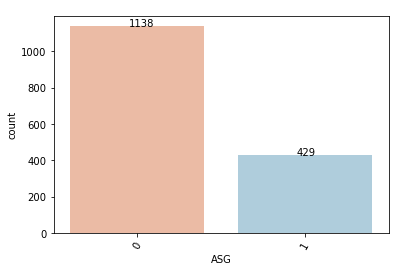

<IPython.core.display.Javascript object>

In [27]:
labeled_bar(df, "ASG")

In [28]:
print("The distribution of players who were selected for the All-star game: ")
round(df["ASG"].value_counts(1), 3)

The distribution of players who were selected for the All-star game: 


0    0.726
1    0.274
Name: ASG, dtype: float64

<IPython.core.display.Javascript object>

- This dataset contains only qualifying players who finished the season with 3.1 Plate Appearance per Team Game, therefore these players likely completed the season without major injury, being replaced for poor performance, or missing a significant number of games.
    - Of the players in the dataset, 27.4% were selected for the All Star Game, or 429 of the 1567 players

In [29]:
# Creating data sub-set to seperate players selected for All-Star Game
as_yes = df[df["ASG"] == 1]

<IPython.core.display.Javascript object>

### All-Stars by League

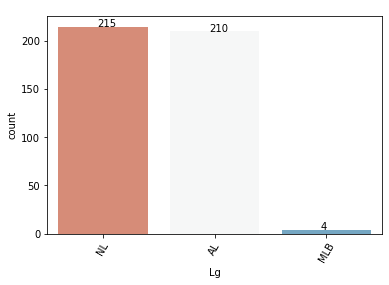

<IPython.core.display.Javascript object>

In [30]:
labeled_bar(as_yes, "Lg")

- As should be expected, the number of All-Stars selected between the American and National Leagues are almost equal.
- The teams are divided among leagues and small differences can be justified as players being selected who haven't met the plate appearance qualifier and/or the need to select injury replacements for players who were selected but unable to participate.
- The 4 All-Star players selected that show league 'MLB' were traded during the season and switched leagues in the process, this is very rare and doesn't warrant or require further exploration.

### Statistical Columns (All Players)

In [31]:
stat_cols = [
    "G",
    "PA",
    "AB",
    "R",
    "H",
    "2B",
    "3B",
    "HR",
    "RBI",
    "SB",
    "CS",
    "SO",
    "BB",
    "BA",
    "OBP",
    "SLG",
    "OPS",
    "OPS+",
    "TB",
    "GDP",
    "HBP",
    "SH",
    "SF",
    "IBB",
]

<IPython.core.display.Javascript object>

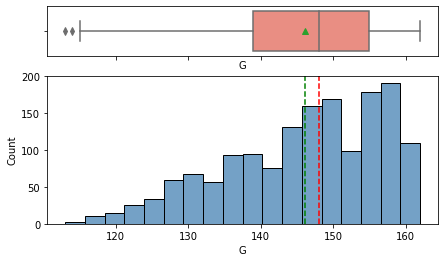

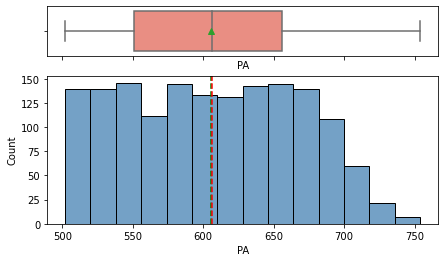

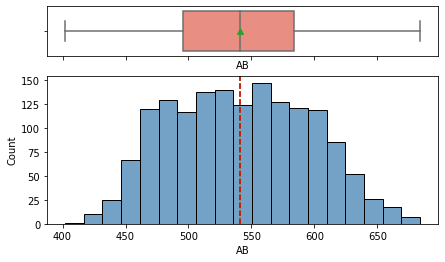

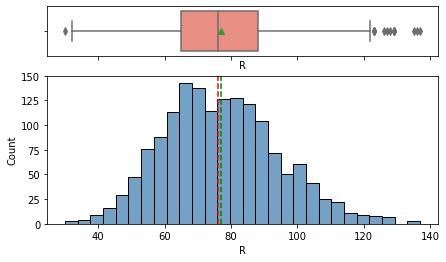

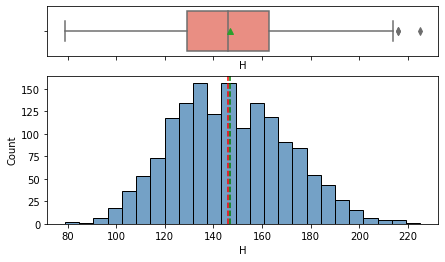

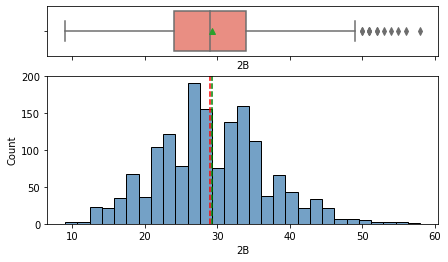

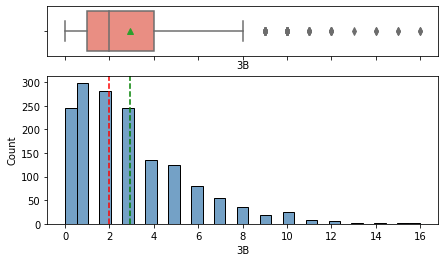

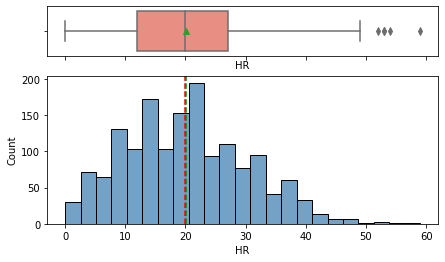

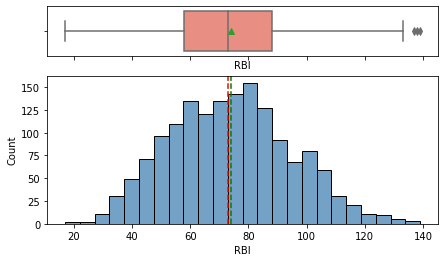

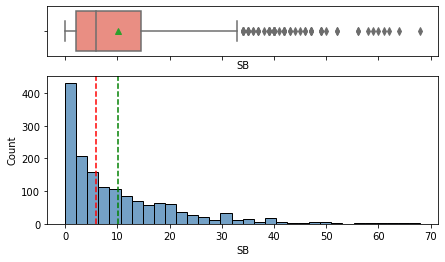

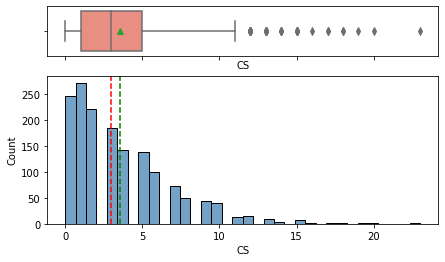

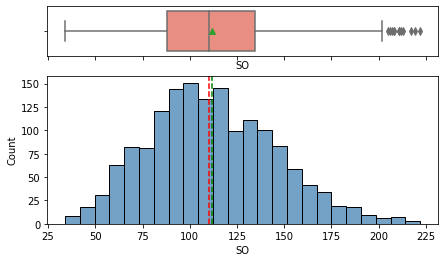

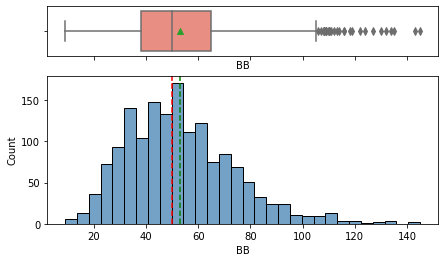

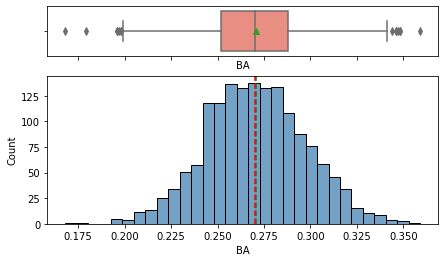

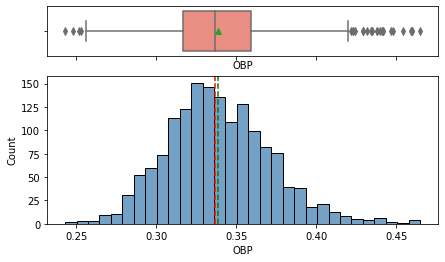

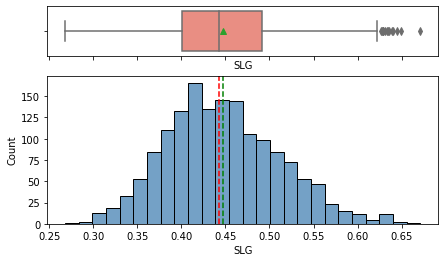

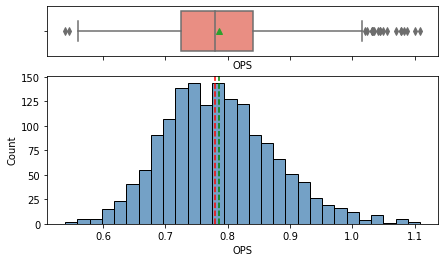

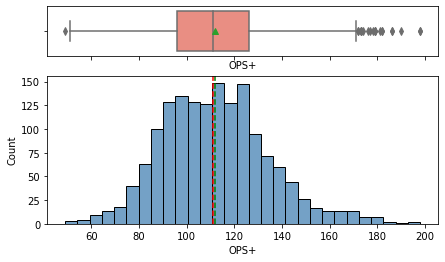

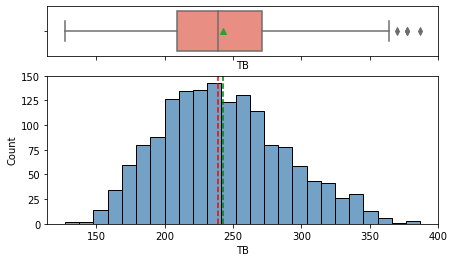

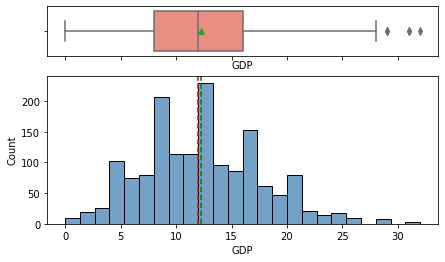

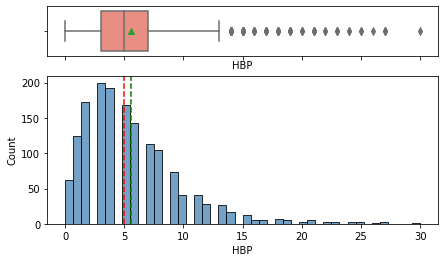

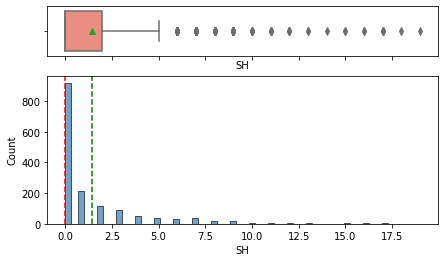

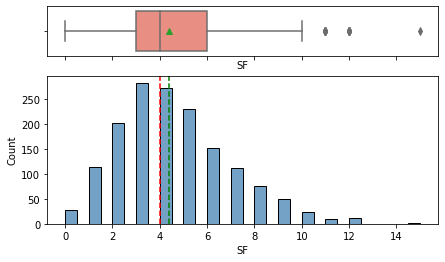

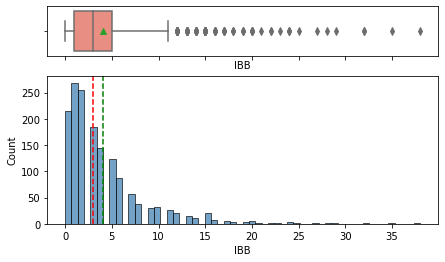

<IPython.core.display.Javascript object>

In [32]:
for feature in stat_cols:
    hist_boxplot(df, feature, figsize=(7, 4))

*In analyzing the statistical categories in this dataset, it is important to remember that this only includes players who average 3.1 plate appearance per team game played.  Therefore, these are the batters who have participated for more or less a full season over the last 10 full years*

##### Most statistical categories follow a normal distribution, some observations from those that are skewed:

- Triples (3B), the average number of triples per season is close to 3 and to have more than 4 is in the 75th percentile, this number is surprising low given that the average number of plate appearances is just over 600.
- Stolen Bases (SB), the average number per season is 10, and to have more than 13 is in the 75th percentile.  To have more than 32 in a season is an outlier and could be considered elite.
- Caught Stealing (CS), its quite intuitive for this to follow a similar distribution as Stolen Bases and it does.  These represent outliers, but hard to believe there are 2 players to have seasons of being caught on 20 or more occasions.
- Walks (BB), the average per season is approximately 54 and to have more than 63 is in the 75th percentile.  Players with season with over 100 walks are elite and a real threat at the plate.
- Hit by Pitch (HBP), the average per season is approximately 5 and to have more than 7 is in the 75th percentile.
- Sacrifice Bunts (SH), the average per season is below 2 and to have more than 2 is in the 75th percentile, it is disappointing that this traditional strategy is largely overlooked in the modern game.
- Intentional Walks (IBB), the average per season is approximately 4 and to have more than 5 is in the 75th percentile.

##### The distribution of a number of these statistics shows that speed and some small-ball strategies are not valued in the modern game.  It will be interesting to see how these same statistics are distributed among All-Star players.  It seems statistics like Triples, Stolen Bases, and Sacrifice Bunts may not be common among the game's most valued players.

### Statistical Columns (All-Star Players)

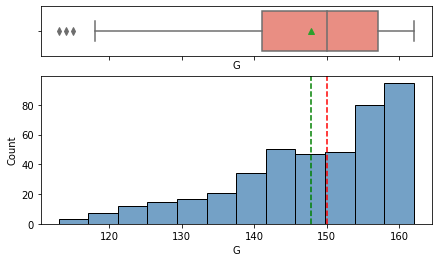

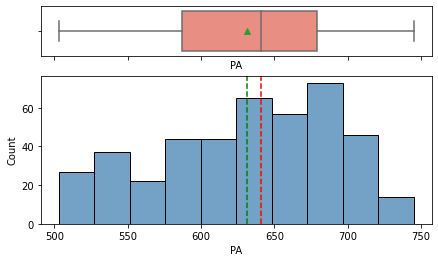

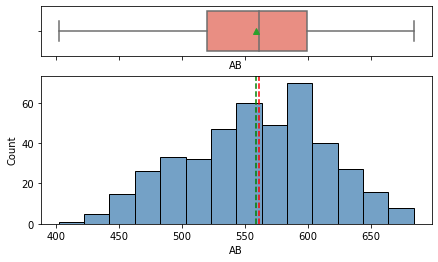

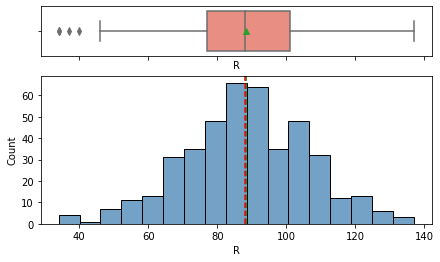

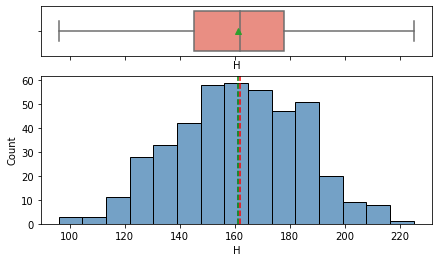

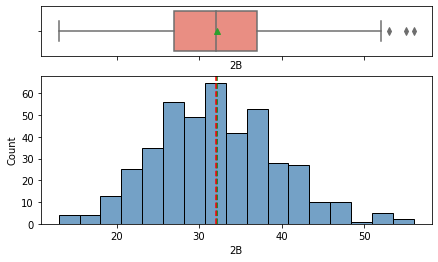

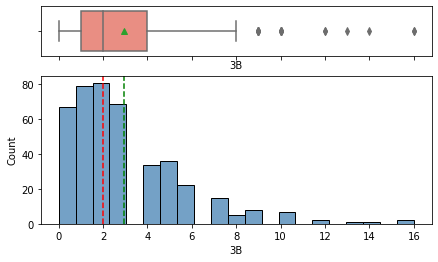

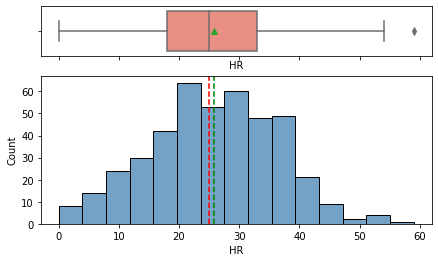

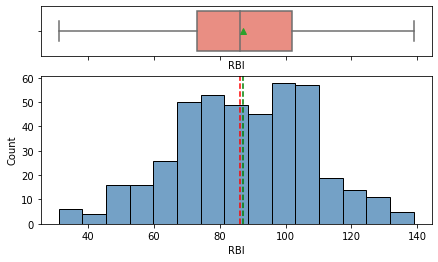

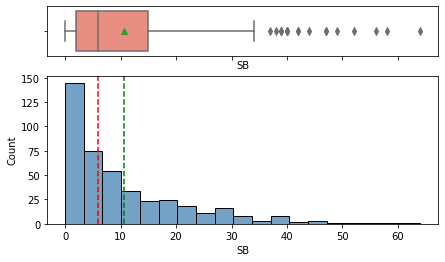

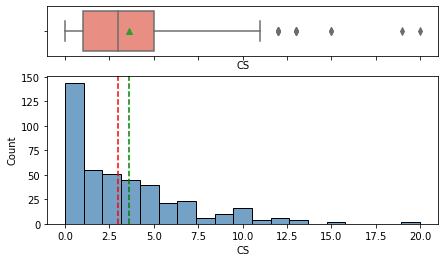

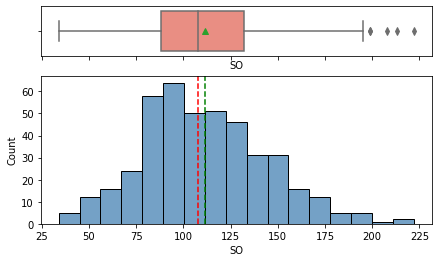

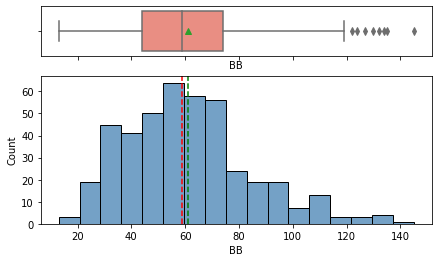

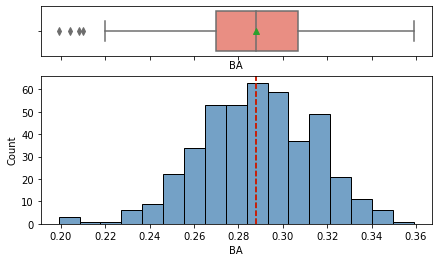

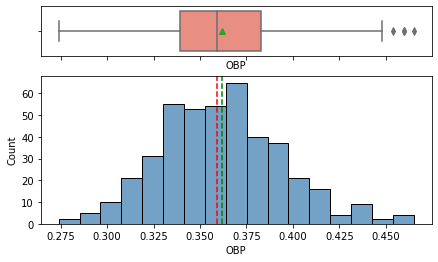

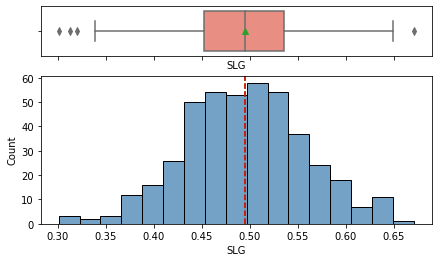

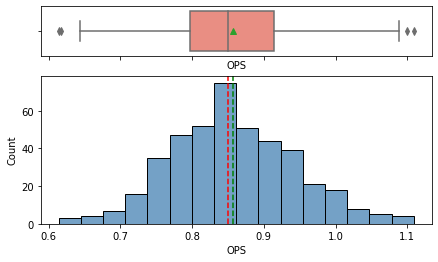

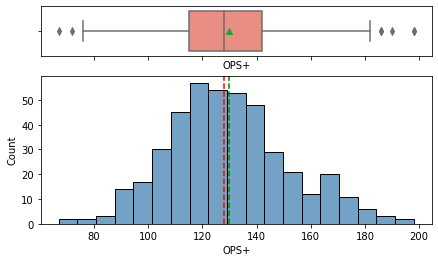

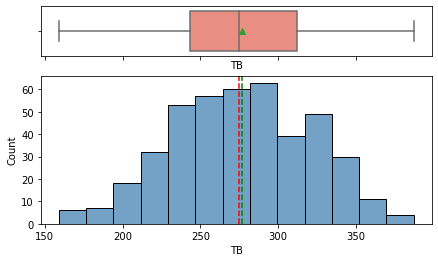

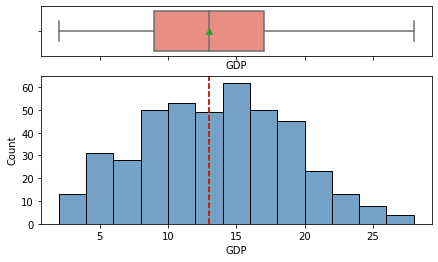

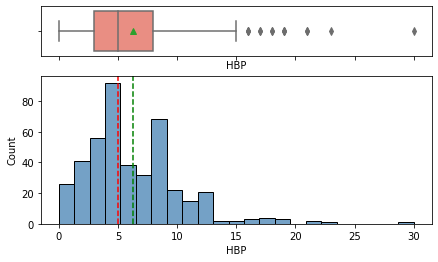

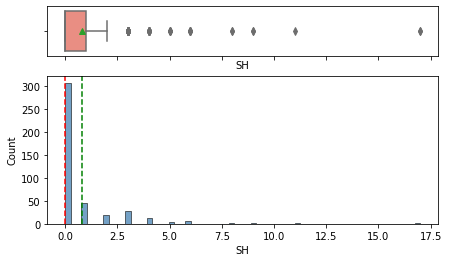

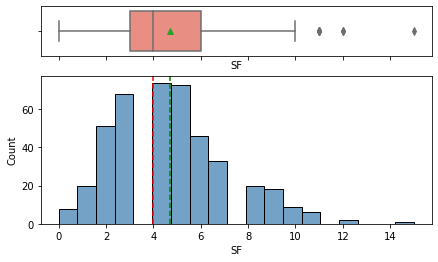

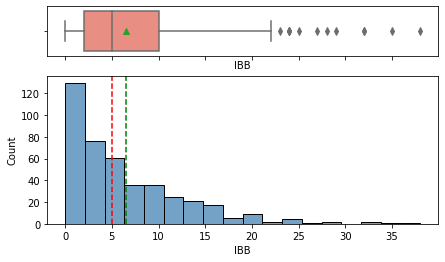

<IPython.core.display.Javascript object>

In [33]:
for feature in stat_cols:
    hist_boxplot(as_yes, feature, figsize=(7, 4))

In [34]:
nrun = round(np.mean(df["R"]), 2)
yrun = round(np.mean(as_yes["R"]), 2)
nhit = round(np.mean(df["H"]), 2)
yhit = round(np.mean(as_yes["H"]), 2)
ndub = round(np.mean(df["2B"]), 2)
ydub = round(np.mean(as_yes["2B"]), 2)
ntrip = round(np.mean(df["3B"]), 2)
ytrip = round(np.mean(as_yes["3B"]), 2)
nhr = round(np.mean(df["HR"]), 2)
yhr = round(np.mean(as_yes["HR"]), 2)
nrbi = round(np.mean(df["RBI"]), 2)
yrbi = round(np.mean(as_yes["RBI"]), 2)
nsb = round(np.mean(df["SB"]), 2)
ysb = round(np.mean(as_yes["SB"]), 2)
nso = round(np.mean(df["SO"]), 2)
yso = round(np.mean(as_yes["SO"]), 2)
nbb = round(np.mean(df["BB"]), 2)
ybb = round(np.mean(as_yes["BB"]), 2)
nba = round(np.mean(df["BA"]), 3)
yba = round(np.mean(as_yes["BA"]), 3)
nopsp = round(np.mean(df["OPS+"]), 2)
yopsp = round(np.mean(as_yes["OPS+"]), 2)
ntb = round(np.mean(df["TB"]), 2)
ytb = round(np.mean(as_yes["TB"]), 2)

<IPython.core.display.Javascript object>

In [35]:
st = {
    "Runs": [nrun, yrun],
    "Hits": [nhit, yhit],
    "Doubles": [ndub, ydub],
    "Triple": [ntrip, ytrip],
    "Home Runs": [nhr, yhr],
    "RBIs": [nrbi, yrbi],
    "Stolen Bases": [nsb, ysb],
    "Strike Outs": [nso, yso],
    "Walks": [nbb, ybb],
    "Batting Average": [nba, yba],
    "OPS+": [nopsp, yopsp],
    "Total Bases": [ntb, ytb],
}
measure = ["Dataset Avg", "ASG Player Avg"]
df_spec = pd.DataFrame(st, index=measure)
df_spec

,Runs,Hits,Doubles,Triple,Home Runs,RBIs,Stolen Bases,Strike Outs,Walks,Batting Average,OPS+,Total Bases
Dataset Avg,76.98,146.83,29.26,2.92,20.14,73.89,10.08,111.95,52.95,0.271,111.99,242.37
ASG Player Avg,88.44,161.10,32.20,2.95,25.74,87.05,10.61,111.44,61.02,0.288,129.67,276.42


<IPython.core.display.Javascript object>

- All-Star batters should be selected as the very best at their given position.  Among All-Stars, the biggest statistical differences are the following:
    - Average 12 more runs scored per season than the average player
    - 15 more hits per season
    - 5 more home runs per season
    - 14 more RBIs per season
    - 9 more walks per season
    - .018 points on batting average
    - 18 points in OPS+
    - 34 more Total Bases per season

### Age (All Players)

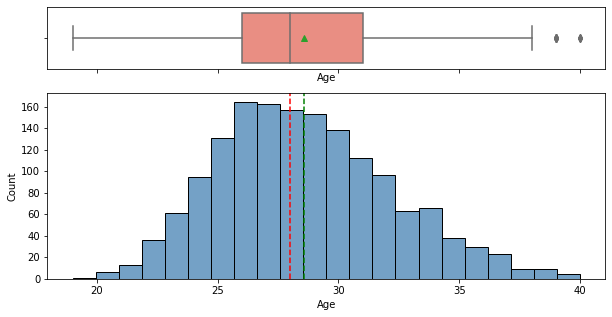

<IPython.core.display.Javascript object>

In [36]:
hist_boxplot(df, "Age", bins=22)

- The average age of players in the dataset is approximately 29.
- 50% of the players in the dataset are aged between 26 and 31.  This age range coincides with a range traditionally considered to be the 'prime years' of a player's career, during which time one could expect to see peak performance.

### Age (All-Star Players)

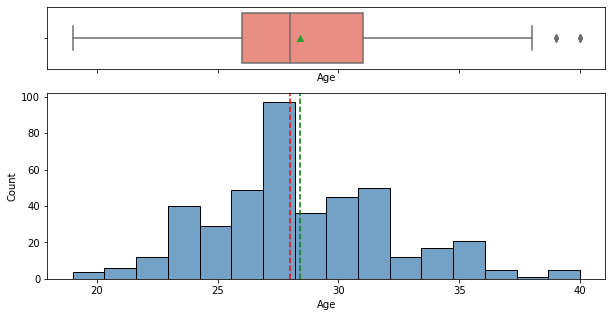

<IPython.core.display.Javascript object>

In [37]:
hist_boxplot(as_yes, "Age")

In [38]:
print("The average age of an MLB All-Star is: ", round(np.mean(as_yes["Age"]), 2))
print("The median age of an MLB All_star is: ", round(np.median(as_yes["Age"]), 2))

The average age of an MLB All-Star is:  28.41
The median age of an MLB All_star is:  28.0


<IPython.core.display.Javascript object>

- Age seems to play no role in predicting All-Star Players.  The mean, median, and distribution are almost exactly the same across the overall dataset and those who have been selected to the ASG.
- The average age of an MLB All-Star is 28.41, and it still remains true to say the 'Prime Years' of an MLB player's career is between 26 and 31.

### Top Players

In [39]:
df["Name"].value_counts().loc[lambda x: x > 8]

Elvis Andrus        10
Miguel Cabrera      10
Andrew McCutchen    10
Eric Hosmer         10
Adam Jones          10
Carlos Santana      10
Asdrubal Cabrera     9
Brett Gardner        9
Alcides Escobar      9
Freddie Freeman      9
Jose Altuve          9
Justin Upton         9
Starlin Castro       9
Joey Votto           9
Evan Longoria        9
Nelson Cruz          9
Name: Name, dtype: int64

<IPython.core.display.Javascript object>

In [40]:
as_yes["Name"].value_counts().loc[lambda x: x > 4]

Mike Trout          8
Miguel Cabrera      7
Robinson Cano       7
Jose Altuve         7
Yadier Molina       7
Salvador Perez      6
Nolan Arenado       6
Andrew McCutchen    5
Manny Machado       5
Paul Goldschmidt    5
Freddie Freeman     5
Jose Bautista       5
Mookie Betts        5
Nelson Cruz         5
Buster Posey        5
Joey Votto          5
Name: Name, dtype: int64

<IPython.core.display.Javascript object>

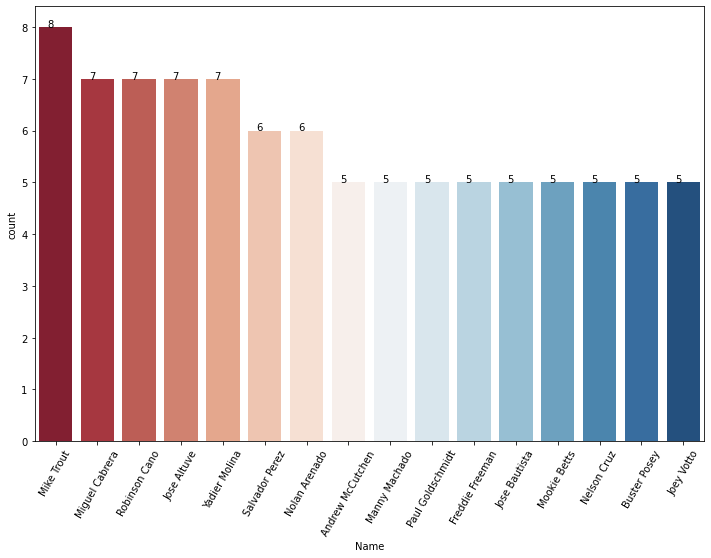

<IPython.core.display.Javascript object>

In [41]:
plt.figure(figsize=(12, 8))
ax = sns.countplot(
    data=as_yes,
    x="Name",
    palette="RdBu",
    order=as_yes.Name.value_counts().iloc[:16].index,
)
for p in ax.patches:
    ax.annotate(f"\n{p.get_height()}", (p.get_x() + 0.2, p.get_height()))

plt.xticks(rotation=60)
plt.show()

- There are 6 players to appear in the dataset for each of the 10 years selected: Andrew McCutcheon, Miguel Cabrera, Adam Jones, Eric Hosmer, Carlos Santana, and Elvis Andrus.
    - These players maintained a long track record of staying healthy and consistently available for their teams.
- The 5 players with the most All-Star game selections are: Mike Trout, Robinson Cano, Yadier Molina, Jose Altuve, and Miguel Cabrera.    

### All-Stars by Team

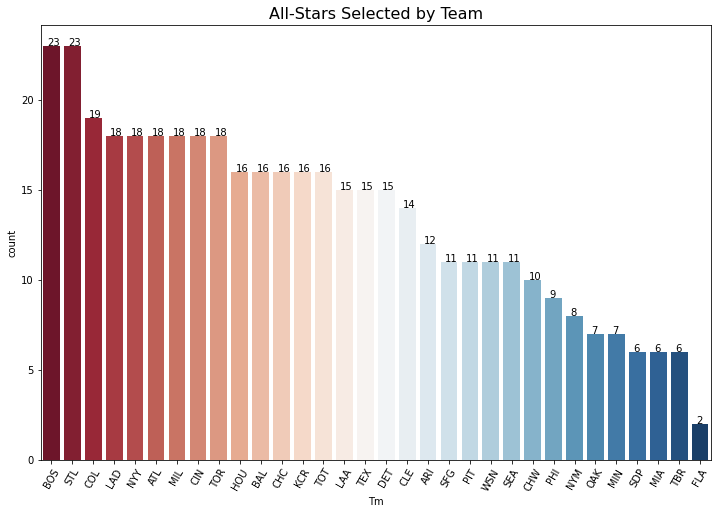

<IPython.core.display.Javascript object>

In [42]:
plt.figure(figsize=(12, 8))
ax = sns.countplot(
    data=as_yes,
    x="Tm",
    palette="RdBu",
    order=as_yes["Tm"].value_counts(ascending=False).index,
)
for p in ax.patches:
    ax.annotate(f"\n{p.get_height()}", (p.get_x() + 0.2, p.get_height()))
plt.title("All-Stars Selected by Team", fontsize=16)
plt.xticks(rotation=60)
plt.show()

- The teams that have had the most All-Star batters selected for the previous 10 All-Star Games are the Boston Red Sox and the St. Louis Cardinals.
    - Team listed at 'TOT' indicates the player was traded before the end of the season.
    - Team listed as MIA is the same as FLA, as the Florida Marlins switched names to the Miami Marlins to start the 2012 season.

### Batters by Handedness

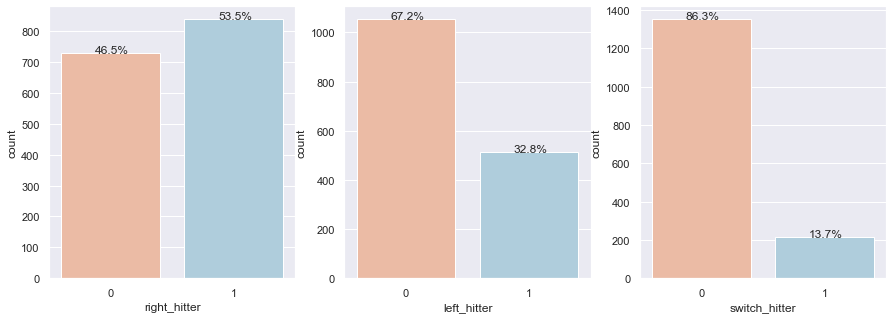

<IPython.core.display.Javascript object>

In [43]:
plt.figure(figsize=(15, 5))
sns.set_theme(style="darkgrid")

plt.subplot(1, 3, 1)
ax = sns.countplot(data=df, x="right_hitter", palette="RdBu")
for p in ax.patches:
    percentage = "{:.1f}%".format(100 * p.get_height() / len(df))
    x = p.get_x() - 0.25 + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha="right")

plt.subplot(1, 3, 2)
ax = sns.countplot(data=df, x="left_hitter", palette="RdBu")
for p in ax.patches:
    percentage = "{:.1f}%".format(100 * p.get_height() / len(df))
    x = p.get_x() - 0.25 + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha="right")

plt.subplot(1, 3, 3)
ax = sns.countplot(data=df, x="switch_hitter", palette="RdBu")
for p in ax.patches:
    percentage = "{:.1f}%".format(100 * p.get_height() / len(df))
    x = p.get_x() - 0.25 + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha="right")

plt.show()

In [44]:
right = df[df["right_hitter"] == 1]
left = df[df["left_hitter"] == 1]
switch = df[df["switch_hitter"] == 1]

print("The number of right handed hitters: ", len(right))
print("The number of left handed hitters: ", len(left))
print("The number of switch hitters: ", len(switch))

The number of right handed hitters:  838
The number of left handed hitters:  514
The number of switch hitters:  215


<IPython.core.display.Javascript object>

 - 53.5% of all players in the dataset bat right-handed, and only 13.7% are switch-hitters.
 - It would seem that left-handed hitters and switch-hitters would have advantages in team building due to being in the minority, but it will be interesting to see if and how this affects All-Star Selections.

### Primary Position

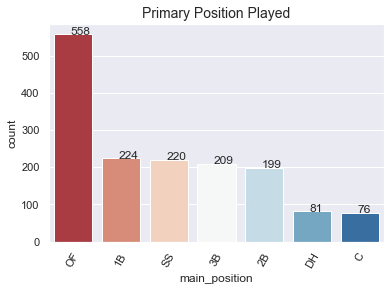

<IPython.core.display.Javascript object>

In [45]:
plt.title("Primary Position Played", fontsize=14)
labeled_bar(df, "main_position")

- Distribution of positions in the dataset all make sense:
    - All 4 infield positions (1B, 2B, SS, and 3B) are all relatively equal
    - Outfield positions (LF, CF, and RF) have been combined and almost total 3x the infield positions
    - DH was strictly employed only in American League (AL) ballparks until 2022, and thus would have a lower total
    - Catcher (C) is the most physically taxing position, being that the position is played in a physically crouched position and subject to being struck by batted balls, and thus these players take the most off-days.  Given the dataset's qualification of 3.1 plate appearance per team game, this is the hardest to meet at this position.

### All-Stars Selected by Position

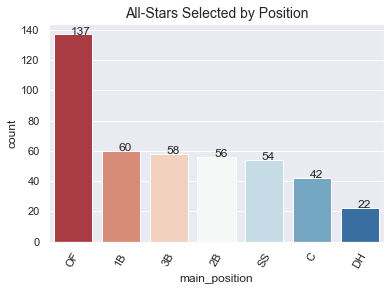

<IPython.core.display.Javascript object>

In [46]:
plt.title("All-Stars Selected by Position", fontsize=14)
labeled_bar(as_yes, "main_position")

In [47]:
print(
    "Percentages of Players selected to All-Star Game from each position within dataset: "
)
print(
    "OF: ",
    round(
        (
            (
                as_yes[as_yes["main_position"] == "OF"].value_counts().sum()
                / df[df["main_position"] == "OF"].value_counts().sum()
            )
            * 100
        ),
        2,
    ),
)
print(
    "1B: ",
    round(
        (
            (
                as_yes[as_yes["main_position"] == "1B"].value_counts().sum()
                / df[df["main_position"] == "1B"].value_counts().sum()
            )
            * 100
        ),
        2,
    ),
)
print(
    "3B: ",
    round(
        (
            (
                as_yes[as_yes["main_position"] == "3B"].value_counts().sum()
                / df[df["main_position"] == "3B"].value_counts().sum()
            )
            * 100
        ),
        2,
    ),
)
print(
    "2B: ",
    round(
        (
            (
                as_yes[as_yes["main_position"] == "2B"].value_counts().sum()
                / df[df["main_position"] == "2B"].value_counts().sum()
            )
            * 100
        ),
        2,
    ),
)
print(
    "SS: ",
    round(
        (
            (
                as_yes[as_yes["main_position"] == "SS"].value_counts().sum()
                / df[df["main_position"] == "SS"].value_counts().sum()
            )
            * 100
        ),
        2,
    ),
)
print(
    "C: ",
    round(
        (
            (
                as_yes[as_yes["main_position"] == "C"].value_counts().sum()
                / df[df["main_position"] == "C"].value_counts().sum()
            )
            * 100
        ),
        2,
    ),
)
print(
    "DH: ",
    round(
        (
            (
                as_yes[as_yes["main_position"] == "DH"].value_counts().sum()
                / df[df["main_position"] == "DH"].value_counts().sum()
            )
            * 100
        ),
        2,
    ),
)

Percentages of Players selected to All-Star Game from each position within dataset: 
OF:  24.55
1B:  26.79
3B:  27.75
2B:  28.14
SS:  24.55
C:  55.26
DH:  27.16


<IPython.core.display.Javascript object>

- Within the dataset, percentages of All-Star Players selected from each position remains relatively close to the overall average of 27.4%.
- The exception to this is at Catcher (C).  Again, this is explainable as many catchers don't qualify for the dataset as they average much fewer plate appearances due to the physically taxing nature of their position.
- These percentages really don't indicate that players at certain positions are selected for the All-Star game more often than other positions.

### OPS+ by Position

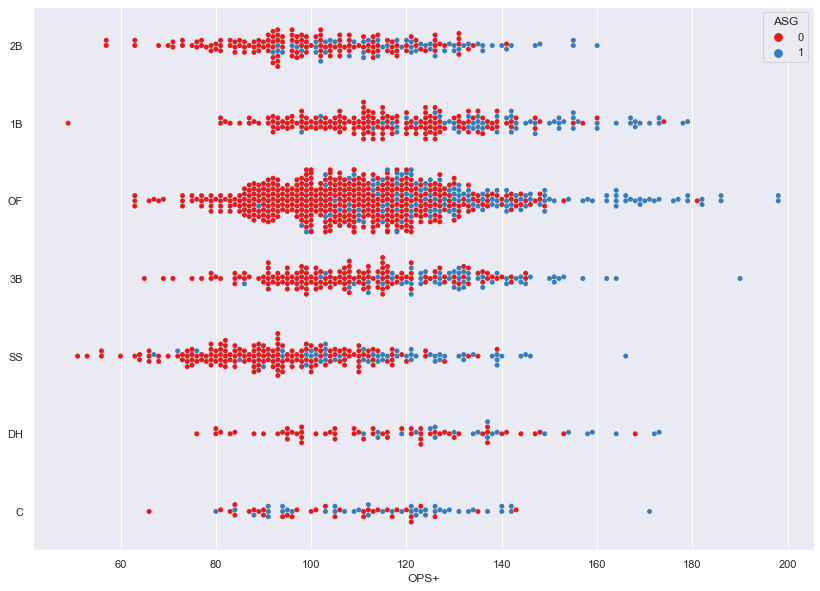

<IPython.core.display.Javascript object>

In [48]:
plt.figure(figsize=(14, 10))
ax = sns.swarmplot(data=df, x="OPS+", y="main_position", hue="ASG", palette="Set1")
plt.ylabel("")
plt.show()

In [49]:
as_2b = as_yes[as_yes["main_position"] == "2B"]
a2bo = round(np.mean(as_2b["OPS+"]), 2)
as_1b = as_yes[as_yes["main_position"] == "1B"]
a1bo = round(np.mean(as_1b["OPS+"]), 2)
as_of = as_yes[as_yes["main_position"] == "OF"]
aofo = round(np.mean(as_of["OPS+"]), 2)
as_3b = as_yes[as_yes["main_position"] == "3B"]
a3bo = round(np.mean(as_3b["OPS+"]), 2)
as_ss = as_yes[as_yes["main_position"] == "SS"]
asso = round(np.mean(as_ss["OPS+"]), 2)
as_dh = as_yes[as_yes["main_position"] == "DH"]
adho = round(np.mean(as_dh["OPS+"]), 2)
as_c = as_yes[as_yes["main_position"] == "C"]
aco = round(np.mean(as_c["OPS+"]), 2)

<IPython.core.display.Javascript object>

In [50]:
d = {
    "C": [aco],
    "1B": [a1bo],
    "2B": [a2bo],
    "3B": [a3bo],
    "SS": [asso],
    "OF": [aofo],
    "DH": [adho],
}
ind = ["Avg OPS+ for All-Stars"]
posdf = pd.DataFrame(d, index=ind)
posdf

,C,1B,2B,3B,SS,OF,DH
Avg OPS+ for All-Stars,116.21,142.98,119.91,131.36,115.7,135.4,138.0


<IPython.core.display.Javascript object>

### All-Stars Traded Mid-season

In [51]:
as_traded = as_yes[as_yes["Tm"] == "TOT"]
as_traded.head(20)

,Name,Year,Age,Tm,Lg,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,BA,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB,ASG,left_hitter,switch_hitter,right_hitter,main_position
114,Trea Turner,2021,28,TOT,NL,148,646,595,107,195,34,3,28,77,32,5,41,110,0.328,0.375,0.536,0.911,146,319,18,6,0,4,2,1,0,0,1,SS
116,Nelson Cruz,2021,40,TOT,AL,140,584,513,79,136,21,1,32,86,3,0,51,126,0.265,0.334,0.497,0.832,130,255,14,7,0,9,10,1,0,0,1,DH
117,Kris Bryant,2021,29,TOT,NL,144,586,513,86,136,32,2,25,73,10,2,62,135,0.265,0.353,0.481,0.835,123,247,9,9,0,2,4,1,0,0,1,3B
118,Joey Gallo,2021,27,TOT,AL,153,616,498,90,99,13,1,38,77,6,0,111,213,0.199,0.351,0.458,0.808,121,228,6,6,0,1,5,1,1,0,0,OF
121,Adam Frazier,2021,29,TOT,NL,155,639,577,83,176,36,5,5,43,10,5,48,69,0.305,0.368,0.411,0.779,114,237,10,10,3,1,2,1,1,0,0,2B
123,Eduardo Escobar,2021,32,TOT,NL,146,599,549,77,139,26,5,28,90,1,0,48,124,0.253,0.314,0.472,0.786,109,259,3,1,0,1,1,1,0,1,0,3B
395,Manny Machado,2018,25,TOT,MLB,162,709,632,84,188,35,3,37,107,14,2,70,104,0.297,0.367,0.538,0.905,145,340,26,2,0,5,18,1,0,0,1,SS
542,Yonder Alonso,2017,30,TOT,AL,142,521,451,72,120,22,0,28,67,2,0,68,118,0.266,0.365,0.501,0.866,134,226,9,2,0,0,6,1,1,0,0,1B
685,Jonathan Lucroy,2016,30,TOT,MLB,142,544,490,67,143,24,3,24,81,5,0,47,100,0.292,0.355,0.500,0.855,123,245,16,3,0,4,5,1,0,0,1,C
686,Carlos Beltran,2016,39,TOT,AL,151,593,552,73,163,33,0,29,93,1,0,35,101,0.295,0.337,0.513,0.850,122,283,19,2,0,4,4,1,0,1,0,DH


<IPython.core.display.Javascript object>

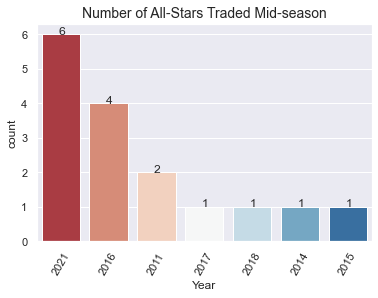

<IPython.core.display.Javascript object>

In [52]:
plt.title("Number of All-Stars Traded Mid-season", fontsize=14)
labeled_bar(as_traded, "Year")

In [53]:
print(
    "From 2010 - 2021 the percentage of All-Star Batters to be traded midseason: ",
    round((len(as_traded) / (df["ASG"] == 1).value_counts().sum()) * 100, 2),
    "%",
)

From 2010 - 2021 the percentage of All-Star Batters to be traded midseason:  1.02 %


<IPython.core.display.Javascript object>

- In the Dataset, only 1% of all batters selected to the All-Star game are traded within that same season.  The number of impact bats to be added for a playoff push are very limited.  The 2021 season saw mid-season trades for 6 All-Star Batters, this was a banner year to make a key acquisition at the trade deadline.

### Correlation Heatmap

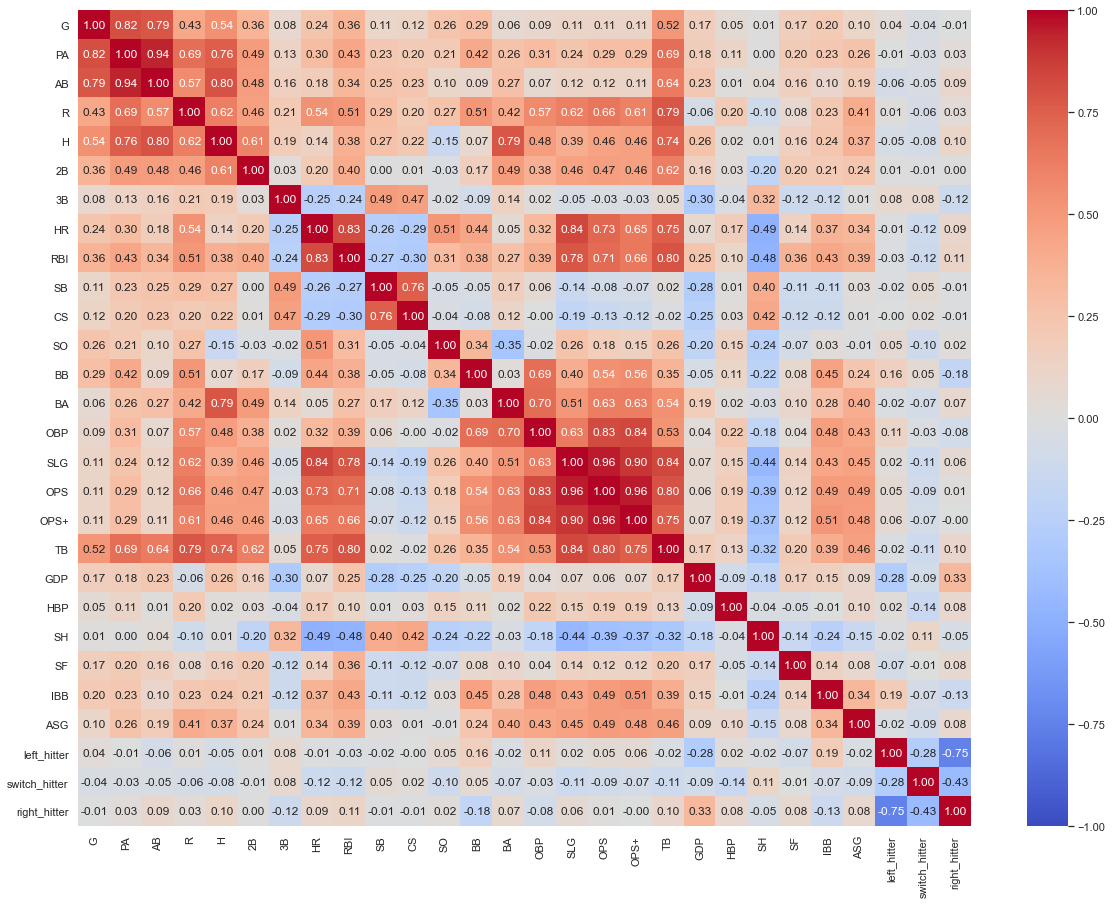

<IPython.core.display.Javascript object>

In [54]:
num_corr = [
    "G",
    "PA",
    "AB",
    "R",
    "H",
    "2B",
    "3B",
    "HR",
    "RBI",
    "SB",
    "CS",
    "SO",
    "BB",
    "BA",
    "OBP",
    "SLG",
    "OPS",
    "OPS+",
    "TB",
    "GDP",
    "HBP",
    "SH",
    "SF",
    "IBB",
    "ASG",
    "left_hitter",
    "switch_hitter",
    "right_hitter",
]
corr = df[num_corr].corr()
plt.figure(figsize=(20, 15))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="coolwarm")
plt.show()

- The variables most positively correlated with All-Star Selection are: runs scored (R), batting average (BA), on base percentage (OBP), slugging percentage (SLG), on base plus slugging (OPS), on base plus slugging + (OPS+), and Total Bases (TB).
    - For model building OPS will be removed, this is because OPS+ is a standardized metric of OPS so these are almost the same metric (96% correlation).
    - There is also very strong correlation between OPS+ with slugging percentage and on base percentage (OPS is a measure of these slugging + on base), these may also need to be removed.
    - Test for multicollinearity will help indicate which others may need to be removed. 

## Prepare Data for Model Building

In [55]:
# copy dataset to maintain pre-model structure
mdata = df.copy()

<IPython.core.display.Javascript object>

In [56]:
# drop irrelevant columns
mdata.drop(["Name", "Tm", "Lg", "G", "AB", "OPS", "Year"], axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [57]:
mdata.head()

,Age,PA,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,BA,OBP,SLG,OPS+,TB,GDP,HBP,SH,SF,IBB,ASG,left_hitter,switch_hitter,right_hitter,main_position
0,27,550,69,128,32,3,11,44,9,4,58,137,0.264,0.341,0.411,104,199,7,0,1,3,1,0,1,0,0,2B
1,25,545,68,133,27,4,11,49,1,0,42,106,0.267,0.328,0.404,98,201,11,4,0,1,1,0,1,0,0,1B
2,33,538,57,126,30,8,8,63,2,1,46,92,0.259,0.325,0.402,97,196,9,3,0,2,3,0,1,0,0,OF
3,31,695,120,180,25,2,31,83,8,3,85,107,0.300,0.393,0.503,133,302,11,8,0,2,15,1,1,0,0,1B
4,24,662,91,179,33,1,33,107,0,1,52,168,0.303,0.367,0.531,132,313,11,12,0,8,2,0,0,0,1,3B


<IPython.core.display.Javascript object>

In [58]:
# convert counting statistical columns to per game basis, this will be needed to be able to fit model to data
mdata["R_ppa"] = round(mdata["R"] / mdata["PA"], 4)
mdata["H_ppa"] = round(mdata["H"] / mdata["PA"], 4)
mdata["2B_ppa"] = round(mdata["2B"] / mdata["PA"], 4)
mdata["3B_ppa"] = round(mdata["3B"] / mdata["PA"], 4)
mdata["HR_ppa"] = round(mdata["HR"] / mdata["PA"], 4)
mdata["RBI_ppa"] = round(mdata["RBI"] / mdata["PA"], 4)
mdata["SB_ppa"] = round(mdata["SB"] / mdata["PA"], 4)
mdata["CS_ppa"] = round(mdata["CS"] / mdata["PA"], 4)
mdata["BB_ppa"] = round(mdata["BB"] / mdata["PA"], 4)
mdata["SO_ppa"] = round(mdata["SO"] / mdata["PA"], 4)
mdata["TB_ppa"] = round(mdata["TB"] / mdata["PA"], 4)
mdata["GDP_ppa"] = round(mdata["GDP"] / mdata["PA"], 4)
mdata["HBP_ppa"] = round(mdata["HBP"] / mdata["PA"], 4)
mdata["SH_ppa"] = round(mdata["SH"] / mdata["PA"], 4)
mdata["SF_ppa"] = round(mdata["SF"] / mdata["PA"], 4)
mdata["IBB_ppa"] = round(mdata["IBB"] / mdata["PA"], 4)

<IPython.core.display.Javascript object>

In [59]:
# drop raw counting stat columns
mdata.drop(
    ["H", "2B", "3B", "HR", "SB", "CS", "BB", "SO", "TB", "GDP", "HBP", "SH", "SF",],
    axis=1,
    inplace=True,
)

<IPython.core.display.Javascript object>

In [60]:
# drop games played column, and drop right_hitter column (effectively creates dummy variable for hitting handedness)
mdata.drop(["PA", "right_hitter"], axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [61]:
mdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            1567 non-null   int64  
 1   R              1567 non-null   int64  
 2   RBI            1567 non-null   int64  
 3   BA             1567 non-null   float64
 4   OBP            1567 non-null   float64
 5   SLG            1567 non-null   float64
 6   OPS+           1567 non-null   int64  
 7   IBB            1567 non-null   int64  
 8   ASG            1567 non-null   int64  
 9   left_hitter    1567 non-null   int32  
 10  switch_hitter  1567 non-null   int32  
 11  main_position  1567 non-null   object 
 12  R_ppa          1567 non-null   float64
 13  H_ppa          1567 non-null   float64
 14  2B_ppa         1567 non-null   float64
 15  3B_ppa         1567 non-null   float64
 16  HR_ppa         1567 non-null   float64
 17  RBI_ppa        1567 non-null   float64
 18  SB_ppa  

<IPython.core.display.Javascript object>

In [62]:
mdata.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1567.0,28.560306,3.778514,19.0000,26.00000,28.0000,31.00000,40.0000
R,1567.0,76.977664,17.370470,30.0000,65.00000,76.0000,88.00000,137.0000
RBI,1567.0,73.887045,20.982493,17.0000,58.00000,73.0000,88.00000,139.0000
BA,1567.0,0.270558,0.027072,0.1680,0.25200,0.2700,0.28800,0.3590
OBP,1567.0,0.338902,0.032646,0.2430,0.31700,0.3370,0.35900,0.4650
SLG,1567.0,0.447031,0.064713,0.2680,0.40050,0.4430,0.49100,0.6710
OPS+,1567.0,111.985322,22.529088,49.0000,96.00000,111.0000,126.00000,198.0000
IBB,1567.0,4.063178,4.439083,0.0000,1.00000,3.0000,5.00000,38.0000
ASG,1567.0,0.273772,0.446035,0.0000,0.00000,0.0000,1.00000,1.0000
left_hitter,1567.0,0.328015,0.469640,0.0000,0.00000,0.0000,1.00000,1.0000


<IPython.core.display.Javascript object>

### Split Data and Get Dummy Variable for Position

In [63]:
X = mdata.drop(["ASG"], axis=1)
y = mdata["ASG"]

X = pd.get_dummies(X, drop_first=True)

<IPython.core.display.Javascript object>

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

<IPython.core.display.Javascript object>

### Creating Functions for Scoring / Confusion Matrix

In [65]:
def model_perf(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1},
        index=[0],
    )

    return df_perf

<IPython.core.display.Javascript object>

In [66]:
def confusion_matrix(model, y_actual, labels=[1, 0]):
    y_predict = model.predict(X_test)
    cm = metrics.confusion_matrix(y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(
        cm,
        index=[i for i in ["Actual - No", "Actual - Yes"]],
        columns=[i for i in ["Predicted - No", "Predicted - Yes"]],
    )
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

<IPython.core.display.Javascript object>

### Fit Random Forest Model

In [67]:
X_train.head()

,Age,R,RBI,BA,OBP,SLG,OPS+,IBB,left_hitter,switch_hitter,R_ppa,H_ppa,2B_ppa,3B_ppa,HR_ppa,RBI_ppa,SB_ppa,CS_ppa,BB_ppa,SO_ppa,TB_ppa,GDP_ppa,HBP_ppa,SH_ppa,SF_ppa,IBB_ppa,main_position_2B,main_position_3B,main_position_C,main_position_DH,main_position_OF,main_position_SS
390,24,76,63,0.253,0.326,0.424,96,2,1,0,0.1421,0.2243,0.0430,0.0037,0.0336,0.1178,0.0224,0.0224,0.0804,0.2374,0.3757,0.0093,0.0206,0.0037,0.0093,0.0037,1,0,0,0,0,0
635,26,68,70,0.276,0.304,0.447,97,2,1,0,0.1139,0.2596,0.0536,0.0034,0.0335,0.1173,0.0117,0.0017,0.0318,0.1374,0.4204,0.0151,0.0101,0.0084,0.0084,0.0034,0,0,0,0,0,1
78,31,76,58,0.290,0.348,0.436,113,3,0,0,0.1340,0.2628,0.0476,0.0053,0.0247,0.1023,0.0159,0.0053,0.0688,0.1376,0.3951,0.0282,0.0159,0.0018,0.0071,0.0053,1,0,0,0,0,0
733,24,97,130,0.287,0.323,0.575,124,13,0,0,0.1459,0.2662,0.0647,0.0060,0.0632,0.1955,0.0030,0.0075,0.0511,0.1654,0.5323,0.0256,0.0060,0.0000,0.0165,0.0195,0,1,0,0,0,0
1262,38,77,55,0.283,0.307,0.390,93,5,1,0,0.1161,0.2685,0.0422,0.0090,0.0136,0.0830,0.0437,0.0106,0.0332,0.0920,0.3695,0.0181,0.0030,0.0075,0.0075,0.0075,0,0,0,0,1,0


<IPython.core.display.Javascript object>

In [68]:
selected_features = [
    "BA",
    "R_ppa",
    "OPS+",
    "RBI_ppa",
    "IBB_ppa",
]

<IPython.core.display.Javascript object>

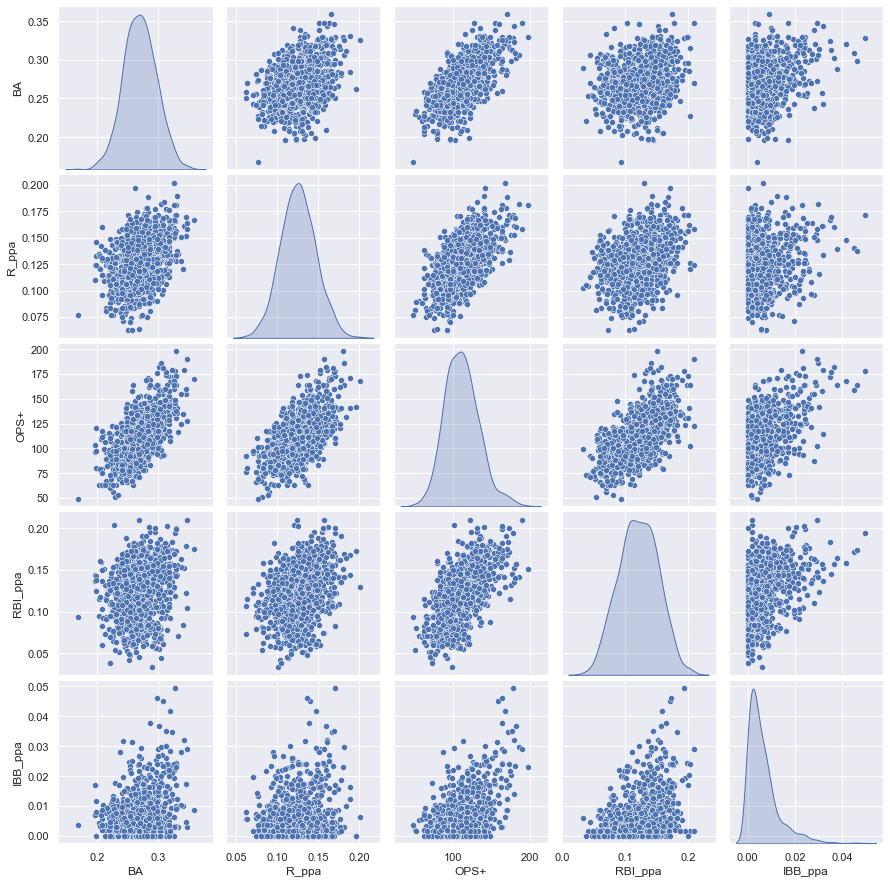

<IPython.core.display.Javascript object>

In [69]:
sns.pairplot(X_train[selected_features], diag_kind="kde")

In [70]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

<IPython.core.display.Javascript object>

In [71]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
BA,1096.0,0.270516,0.027039,0.1680,0.252000,0.27000,0.28800,0.3590
R_ppa,1096.0,0.126020,0.021364,0.0624,0.111475,0.12595,0.14020,0.2019
OPS+,1096.0,111.604015,22.345280,49.0000,96.000000,110.00000,125.00000,198.0000
RBI_ppa,1096.0,0.121424,0.031059,0.0333,0.099800,0.12175,0.14345,0.2101
IBB_ppa,1096.0,0.006403,0.006741,0.0000,0.001700,0.00450,0.00850,0.0494


<IPython.core.display.Javascript object>

In [72]:
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

<IPython.core.display.Javascript object>

In [73]:
model_perf(rf, X_train, y_train)

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


<IPython.core.display.Javascript object>

In [74]:
model_perf(rf, X_test, y_test)

,Accuracy,Recall,Precision,F1
0,0.813163,0.507937,0.711111,0.592593


<IPython.core.display.Javascript object>

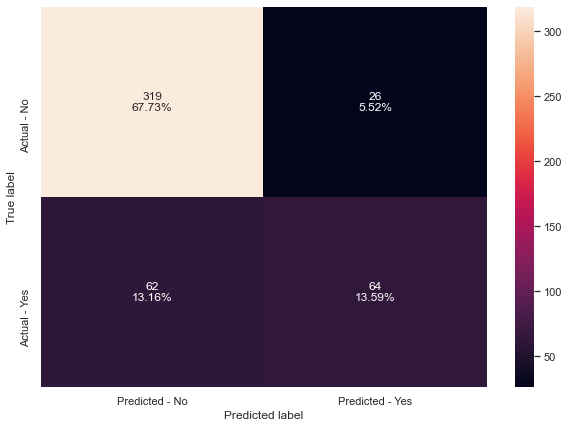

<IPython.core.display.Javascript object>

In [75]:
confusion_matrix(rf, y_test)

### Model Tuning
    

In [76]:
%%time
Model = RandomForestClassifier(random_state=1)
scorer = metrics.make_scorer(metrics.accuracy_score)

param_grid = {"n_estimators": [50,100,150,200,250,300,350], "min_samples_leaf": np.arange(0, 6), "max_features": [np.arange(0.01, 0.99, 0.01),'sqrt'], "max_samples": np.arange(0.01, 0.99, 0.01)}

randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs=-1, scoring=scorer, cv=5, random_state=1)
randomized_cv.fit(X_train, y_train)

print(randomized_cv.best_params_)

{'n_estimators': 150, 'min_samples_leaf': 3, 'max_samples': 0.87, 'max_features': 'sqrt'}
Wall time: 4.67 s


<IPython.core.display.Javascript object>

In [77]:
rf_tuned = RandomForestClassifier(
    n_estimators=150,
    min_samples_leaf=2,
    max_samples=0.23,
    max_features="sqrt",
    random_state=1,
)

rf_tuned.fit(X_train, y_train)

RandomForestClassifier(max_samples=0.23, min_samples_leaf=2, n_estimators=150,
                       random_state=1)

<IPython.core.display.Javascript object>

In [78]:
model_perf(rf_tuned, X_train, y_train)

,Accuracy,Recall,Precision,F1
0,0.843066,0.537954,0.835897,0.654618


<IPython.core.display.Javascript object>

In [79]:
model_perf(rf_tuned, X_test, y_test)

,Accuracy,Recall,Precision,F1
0,0.821656,0.5,0.75,0.6


<IPython.core.display.Javascript object>

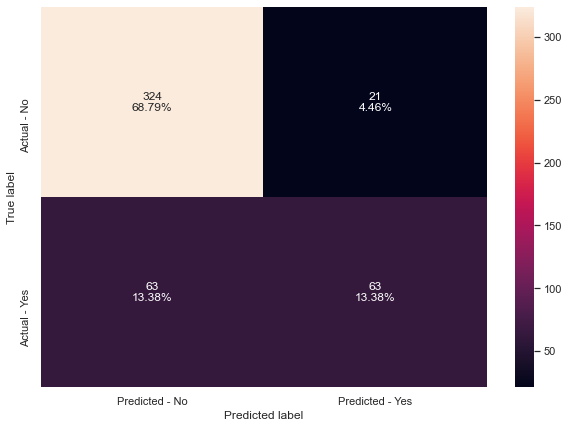

<IPython.core.display.Javascript object>

In [80]:
confusion_matrix(rf_tuned, y_test)

### Feature Importances

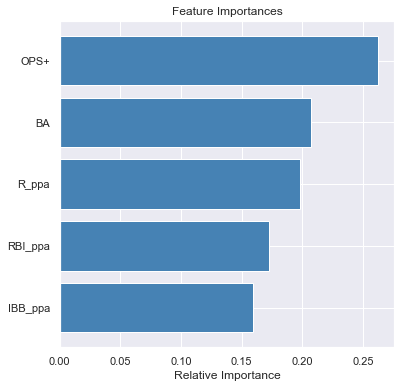

<IPython.core.display.Javascript object>

In [81]:
feature_names = X_train.columns
importances = rf_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(6, 6))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="steelblue", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

In [82]:
yes_asg = mdata[mdata["ASG"] == 1]
no_asg = mdata[mdata["ASG"] == 0]

<IPython.core.display.Javascript object>

In [83]:
opsplusn = round(np.mean(no_asg["OPS+"]), 2)
opsplusy = round(np.mean(yes_asg["OPS+"]), 2)
ban = round(np.mean(no_asg["BA"]), 4)
bay = round(np.mean(yes_asg["BA"]), 4)
rppan = round(np.mean(no_asg["R"]), 2)
rppay = round(np.mean(yes_asg["R"]), 2)
rbippan = round(np.mean(no_asg["RBI"]), 2)
rbippay = round(np.mean(yes_asg["RBI"]), 2)
ibbppan = round(np.mean(no_asg["IBB"]), 2)
ibbppay = round(np.mean(yes_asg["IBB"]), 2)

<IPython.core.display.Javascript object>

In [84]:
keys = {
    "OPS+": [opsplusn, opsplusy],
    "Batting Avg": [ban, bay],
    "Runs Scored": [rppan, rppay],
    "RBI": [rbippan, rbippay],
    "Intentional Walks": [ibbppan, ibbppay],
}
row = ["Non-ASG Player Avg", "ASG Player Avg"]
df_comp = pd.DataFrame(keys, index=row)
df_comp

,OPS+,Batting Avg,Runs Scored,RBI,Intentional Walks
Non-ASG Player Avg,105.32,0.264,72.66,68.93,3.14
ASG Player Avg,129.67,0.288,88.44,87.05,6.52


<IPython.core.display.Javascript object>

### Applying 2022 Data for Prediction

In [85]:
# load data for 2022 performance through 6/22/22 games
newdata = pd.read_excel("C:/Users/Josh/Downloads/mlb_batting_6.23.22.xlsx")

<IPython.core.display.Javascript object>

In [86]:
# interpret symbols in name for batting hand
lh = "*"
newdata["left_hitter"] = newdata["Name"].str.lower().str.endswith(lh)
sh = "#"
newdata["switch_hitter"] = newdata["Name"].str.lower().str.endswith(sh)
newdata["Name"] = newdata["Name"].str.replace("*", "", regex=True)
newdata["Name"] = newdata["Name"].str.replace("#", "", regex=True)

<IPython.core.display.Javascript object>

In [87]:
# create new column for batting hand
conditions = [
    (newdata["left_hitter"] == True),
    (newdata["switch_hitter"] == True),
    (newdata["left_hitter"] == False) & (newdata["switch_hitter"] == False),
]
choices = ["Left", "Switch", "Right"]
newdata["bat_hand"] = np.select(conditions, choices)

newdata.drop(["left_hitter", "switch_hitter"], axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [88]:
# reformatting position summary, and creating new column
newdata["Pos_summary"] = newdata["Pos_summary"].str.replace("*", "", regex=True)
newdata["main_position"] = newdata["Pos_summary"].str[0]
newdata["main_position"] = newdata["main_position"].map(
    {
        "D": "DH",
        "2": "C",
        "3": "1B",
        "4": "2B",
        "5": "3B",
        "6": "SS",
        "7": "OF",
        "8": "OF",
        "9": "OF",
    }
)

<IPython.core.display.Javascript object>

In [89]:
# dropping numerous columns to make dataframe more digestable
newdata.drop(
    [
        "Rk",
        "GDP",
        "HBP",
        "SH",
        "SF",
        "Pos_summary",
        "TB",
        "AB",
        "OBP",
        "SLG",
        "OPS",
        "AB",
        "CS",
        "2B",
        "3B",
        "SB",
        "SO",
    ],
    axis=1,
    inplace=True,
)

<IPython.core.display.Javascript object>

In [90]:
# scaling stats to per plate appearance for model
newdata_train = newdata.copy()
newdata_train["R_ppa"] = round(newdata_train["R"] / newdata_train["PA"], 4)
newdata_train["RBI_ppa"] = round(newdata_train["RBI"] / newdata_train["PA"], 4)
newdata_train["IBB_ppa"] = round(newdata_train["IBB"] / newdata_train["PA"], 4)
newdata_train.head(10)

,Name,Age,Tm,Lg,G,PA,R,H,HR,RBI,BB,BA,OPS+,IBB,bat_hand,main_position,R_ppa,RBI_ppa,IBB_ppa
0,Yordan Álvarez,25,HOU,AL,61,256,45,69,21,51,32,0.315,201,2,Left,DH,0.1758,0.1992,0.0078
1,Paul Goldschmidt,34,STL,NL,67,296,50,87,17,60,36,0.339,197,1,Right,1B,0.1689,0.2027,0.0034
2,Aaron Judge,30,NYY,AL,67,294,57,77,27,52,34,0.302,194,6,Right,OF,0.1939,0.1769,0.0204
3,Jose Ramirez,29,CLE,AL,62,272,44,71,16,62,34,0.302,189,5,Switch,3B,0.1618,0.2279,0.0184
4,Mike Trout,30,LAA,AL,63,262,49,64,21,43,33,0.284,187,2,Right,OF,0.1870,0.1641,0.0076
5,Bryce Harper,29,PHI,NL,61,265,48,76,15,48,26,0.326,184,4,Left,DH,0.1811,0.1811,0.0151
6,Manny Machado,29,SDP,NL,66,285,48,83,12,46,30,0.328,174,6,Right,3B,0.1684,0.1614,0.0211
7,Rafael Devers,25,BOS,AL,68,298,53,90,16,43,20,0.328,167,3,Left,3B,0.1779,0.1443,0.0101
8,Pete Alonso,27,NYM,NL,70,302,43,73,20,66,29,0.282,158,6,Right,1B,0.1424,0.2185,0.0199
9,Luis Arraez,25,MIN,AL,60,245,38,76,4,25,28,0.355,157,1,Left,1B,0.1551,0.1020,0.0041


<IPython.core.display.Javascript object>

In [91]:
newdata_train["ASG"] = rf_tuned.predict(newdata_train[selected_features])

<IPython.core.display.Javascript object>

In [92]:
vote22 = newdata_train[newdata_train["ASG"] == 1]
vote22.head(30)

,Name,Age,Tm,Lg,G,PA,R,H,HR,RBI,BB,BA,OPS+,IBB,bat_hand,main_position,R_ppa,RBI_ppa,IBB_ppa,ASG
0,Yordan Álvarez,25,HOU,AL,61,256,45,69,21,51,32,0.315,201,2,Left,DH,0.1758,0.1992,0.0078,1
1,Paul Goldschmidt,34,STL,NL,67,296,50,87,17,60,36,0.339,197,1,Right,1B,0.1689,0.2027,0.0034,1
2,Aaron Judge,30,NYY,AL,67,294,57,77,27,52,34,0.302,194,6,Right,OF,0.1939,0.1769,0.0204,1
3,Jose Ramirez,29,CLE,AL,62,272,44,71,16,62,34,0.302,189,5,Switch,3B,0.1618,0.2279,0.0184,1
4,Mike Trout,30,LAA,AL,63,262,49,64,21,43,33,0.284,187,2,Right,OF,0.1870,0.1641,0.0076,1
5,Bryce Harper,29,PHI,NL,61,265,48,76,15,48,26,0.326,184,4,Left,DH,0.1811,0.1811,0.0151,1
6,Manny Machado,29,SDP,NL,66,285,48,83,12,46,30,0.328,174,6,Right,3B,0.1684,0.1614,0.0211,1
7,Rafael Devers,25,BOS,AL,68,298,53,90,16,43,20,0.328,167,3,Left,3B,0.1779,0.1443,0.0101,1
8,Pete Alonso,27,NYM,NL,70,302,43,73,20,66,29,0.282,158,6,Right,1B,0.1424,0.2185,0.0199,1
9,Luis Arraez,25,MIN,AL,60,245,38,76,4,25,28,0.355,157,1,Left,1B,0.1551,0.1020,0.0041,1


<IPython.core.display.Javascript object>

In [139]:
mention = vote22.iloc[7:9]
mention2 = vote22.iloc[10:12]
amention = [mention, mention2]
mentdf = pd.concat(amention)
mentdf

,Name,Age,Tm,Lg,G,PA,R,H,HR,RBI,BB,BA,OPS+,IBB,bat_hand,main_position,R_ppa,RBI_ppa,IBB_ppa,ASG
7,Rafael Devers,25,BOS,AL,68,298,53,90,16,43,20,0.328,167,3,Left,3B,0.1779,0.1443,0.0101,1
8,Pete Alonso,27,NYM,NL,70,302,43,73,20,66,29,0.282,158,6,Right,1B,0.1424,0.2185,0.0199,1
10,Ty France,27,SEA,AL,69,309,32,87,10,45,20,0.319,155,1,Right,1B,0.1036,0.1456,0.0032,1
11,J.D. Martinez,34,BOS,AL,60,264,40,76,8,30,25,0.326,153,1,Right,DH,0.1515,0.1136,0.0038,1


<IPython.core.display.Javascript object>

In [93]:
print(
    "The percentage of eligible players identified as All-Stars: ",
    round((len(vote22) / len(newdata)) * 100, 2),
    "%",
)

The percentage of eligible players identified as All-Stars:  15.72 %


<IPython.core.display.Javascript object>

### Roster Breakdown

In [94]:
asg_starters = vote22.groupby(["Lg", "main_position"])
asg_starters.first()

Name  Age   Tm   G   PA   R   H  HR  RBI  BB  \
Lg main_position                                                             
AL 1B                  Luis Arraez   25  MIN  60  245  38  76   4   25  28   
   3B                 Jose Ramirez   29  CLE  62  272  44  71  16   62  34   
   C                Alejandro Kirk   23  TOR  60  220  32  58   8   26  27   
   DH               Yordan Álvarez   25  HOU  61  256  45  69  21   51  32   
   OF                  Aaron Judge   30  NYY  67  294  57  77  27   52  34   
   SS              Xander Bogaerts   29  BOS  68  286  42  85   6   31  25   
NL 1B             Paul Goldschmidt   34  STL  67  296  50  87  17   60  36   
   2B                  Jeff McNeil   30  NYM  65  249  33  74   4   33  19   
   3B                Manny Machado   29  SDP  66  285  48  83  12   46  30   
   DH                 Bryce Harper   29  PHI  61  265  48  76  15   48  26   
   OF                 Mookie Betts   29  LAD  60  275  53  67  17   40  27   
   SS               Dansby Swanson   28  ATL  70  286  44  76  10   38  25   

                     BA  OPS+  IBB bat_hand   R_ppa  RBI_ppa  IBB_ppa  ASG  
Lg main_position                                                            
AL 1B             0.355   157    1     Left  0.1551   0.1020   0.0041    1  
   3B             0.302   189    5   Switch  0.1618   0.2279   0.0184    1  
   C              0.307   151    1    Right  0.1455   0.1182   0.0045    1  
   DH             0.315   201    2     Left  0.1758   0.1992   0.0078    1  
   OF             0.302   194    6    Right  0.1939   0.1769   0.0204    1  
   SS             0.335   144    1    Right  0.1469   0.1084   0.0035    1  
NL 1B             0.339   197    1    Right  0.1689   0.2027   0.0034    1  
   2B             0.327   143    0     Left  0.1325   0.1325   0.0000    1  
   3B             0.328   174    6    Right  0.1684   0.1614   0.0211    1  
   DH             0.326   184    4     Left  0.1811   0.1811   0.0151    1  
   OF             0.273   141    0    Right  0.1927   0.1455   0.0000    1  
   SS             0.295   127    0    Right  0.1538   0.1329   0.0000    1

<IPython.core.display.Javascript object>

In [95]:
asg_starters.apply(display)

,Name,Age,Tm,Lg,G,PA,R,H,HR,RBI,BB,BA,OPS+,IBB,bat_hand,main_position,R_ppa,RBI_ppa,IBB_ppa,ASG
9,Luis Arraez,25,MIN,AL,60,245,38,76,4,25,28,0.355,157,1,Left,1B,0.1551,0.1020,0.0041,1
10,Ty France,27,SEA,AL,69,309,32,87,10,45,20,0.319,155,1,Right,1B,0.1036,0.1456,0.0032,1


,Name,Age,Tm,Lg,G,PA,R,H,HR,RBI,BB,BA,OPS+,IBB,bat_hand,main_position,R_ppa,RBI_ppa,IBB_ppa,ASG
3,Jose Ramirez,29,CLE,AL,62,272,44,71,16,62,34,0.302,189,5,Switch,3B,0.1618,0.2279,0.0184,1
7,Rafael Devers,25,BOS,AL,68,298,53,90,16,43,20,0.328,167,3,Left,3B,0.1779,0.1443,0.0101,1


,Name,Age,Tm,Lg,G,PA,R,H,HR,RBI,BB,BA,OPS+,IBB,bat_hand,main_position,R_ppa,RBI_ppa,IBB_ppa,ASG
12,Alejandro Kirk,23,TOR,AL,60,220,32,58,8,26,27,0.307,151,1,Right,C,0.1455,0.1182,0.0045,1


,Name,Age,Tm,Lg,G,PA,R,H,HR,RBI,BB,BA,OPS+,IBB,bat_hand,main_position,R_ppa,RBI_ppa,IBB_ppa,ASG
0,Yordan Álvarez,25,HOU,AL,61,256,45,69,21,51,32,0.315,201,2,Left,DH,0.1758,0.1992,0.0078,1
11,J.D. Martinez,34,BOS,AL,60,264,40,76,8,30,25,0.326,153,1,Right,DH,0.1515,0.1136,0.0038,1
34,Shohei Ohtani,27,LAA,AL,69,298,44,69,15,45,28,0.260,132,4,Left,DH,0.1477,0.1510,0.0134,1


,Name,Age,Tm,Lg,G,PA,R,H,HR,RBI,BB,BA,OPS+,IBB,bat_hand,main_position,R_ppa,RBI_ppa,IBB_ppa,ASG
2,Aaron Judge,30,NYY,AL,67,294,57,77,27,52,34,0.302,194,6,Right,OF,0.1939,0.1769,0.0204,1
4,Mike Trout,30,LAA,AL,63,262,49,64,21,43,33,0.284,187,2,Right,OF,0.1870,0.1641,0.0076,1
13,Byron Buxton,28,MIN,AL,51,218,38,44,19,33,19,0.228,149,0,Right,OF,0.1743,0.1514,0.0000,1
71,Luis Robert,24,CHW,AL,53,235,32,67,7,36,8,0.300,116,1,Right,OF,0.1362,0.1532,0.0043,1


,Name,Age,Tm,Lg,G,PA,R,H,HR,RBI,BB,BA,OPS+,IBB,bat_hand,main_position,R_ppa,RBI_ppa,IBB_ppa,ASG
17,Xander Bogaerts,29,BOS,AL,68,286,42,85,6,31,25,0.335,144,1,Right,SS,0.1469,0.1084,0.0035,1


,Name,Age,Tm,Lg,G,PA,R,H,HR,RBI,BB,BA,OPS+,IBB,bat_hand,main_position,R_ppa,RBI_ppa,IBB_ppa,ASG
1,Paul Goldschmidt,34,STL,NL,67,296,50,87,17,60,36,0.339,197,1,Right,1B,0.1689,0.2027,0.0034,1
8,Pete Alonso,27,NYM,NL,70,302,43,73,20,66,29,0.282,158,6,Right,1B,0.1424,0.2185,0.0199,1
24,C.J. Cron,32,COL,NL,69,295,44,81,17,52,17,0.300,140,2,Right,1B,0.1492,0.1763,0.0068,1
26,Garrett Cooper,31,MIA,NL,59,242,23,67,5,32,19,0.313,139,0,Right,1B,0.0950,0.1322,0.0000,1


,Name,Age,Tm,Lg,G,PA,R,H,HR,RBI,BB,BA,OPS+,IBB,bat_hand,main_position,R_ppa,RBI_ppa,IBB_ppa,ASG
20,Jeff McNeil,30,NYM,NL,65,249,33,74,4,33,19,0.327,143,0,Left,2B,0.1325,0.1325,0.0,1
28,Jazz Chisholm Jr.,24,MIA,NL,56,229,38,50,14,45,21,0.248,137,0,Left,2B,0.1659,0.1965,0.0,1


,Name,Age,Tm,Lg,G,PA,R,H,HR,RBI,BB,BA,OPS+,IBB,bat_hand,main_position,R_ppa,RBI_ppa,IBB_ppa,ASG
6,Manny Machado,29,SDP,NL,66,285,48,83,12,46,30,0.328,174,6,Right,3B,0.1684,0.1614,0.0211,1
55,Brandon Drury,29,CIN,NL,59,243,42,59,14,35,18,0.267,121,0,Right,3B,0.1728,0.1440,0.0000,1


,Name,Age,Tm,Lg,G,PA,R,H,HR,RBI,BB,BA,OPS+,IBB,bat_hand,main_position,R_ppa,RBI_ppa,IBB_ppa,ASG
5,Bryce Harper,29,PHI,NL,61,265,48,76,15,48,26,0.326,184,4,Left,DH,0.1811,0.1811,0.0151,1


,Name,Age,Tm,Lg,G,PA,R,H,HR,RBI,BB,BA,OPS+,IBB,bat_hand,main_position,R_ppa,RBI_ppa,IBB_ppa,ASG
22,Mookie Betts,29,LAD,NL,60,275,53,67,17,40,27,0.273,141,0,Right,OF,0.1927,0.1455,0.0,1
63,Starling Marte,33,NYM,NL,60,263,45,68,7,36,12,0.278,118,0,Right,OF,0.1711,0.1369,0.0,1


,Name,Age,Tm,Lg,G,PA,R,H,HR,RBI,BB,BA,OPS+,IBB,bat_hand,main_position,R_ppa,RBI_ppa,IBB_ppa,ASG
42,Dansby Swanson,28,ATL,NL,70,286,44,76,10,38,25,0.295,127,0,Right,SS,0.1538,0.1329,0.0,1


""


<IPython.core.display.Javascript object>

##### Top Catchers by League

In [96]:
pos_c = newdata_train[newdata_train["main_position"] == "C"]
nl_c = pos_c[pos_c["Lg"] == "NL"]
nl_c.head(3)

,Name,Age,Tm,Lg,G,PA,R,H,HR,RBI,BB,BA,OPS+,IBB,bat_hand,main_position,R_ppa,RBI_ppa,IBB_ppa,ASG
14,Willson Contreras,30,CHC,NL,60,256,40,58,12,27,26,0.269,147,0,Right,C,0.1562,0.1055,0.0000,0
65,Will Smith,27,LAD,NL,55,225,27,50,9,32,28,0.258,118,1,Right,C,0.1200,0.1422,0.0044,0
105,Daulton Varsho,25,ARI,NL,64,262,32,56,9,28,18,0.237,100,0,Left,C,0.1221,0.1069,0.0000,0


<IPython.core.display.Javascript object>

In [97]:
al_c = pos_c[pos_c["Lg"] == "AL"]
al_c.head(3)

,Name,Age,Tm,Lg,G,PA,R,H,HR,RBI,BB,BA,OPS+,IBB,bat_hand,main_position,R_ppa,RBI_ppa,IBB_ppa,ASG
12,Alejandro Kirk,23,TOR,AL,60,220,32,58,8,26,27,0.307,151,1,Right,C,0.1455,0.1182,0.0045,1
100,Sean Murphy,27,OAK,AL,63,254,25,49,8,28,20,0.216,102,1,Right,C,0.0984,0.1102,0.0039,0
104,Gary Sanchez,29,MIN,AL,54,219,22,43,8,30,15,0.217,100,0,Right,C,0.1005,0.1370,0.0000,0


<IPython.core.display.Javascript object>

##### Top 1B by League

In [98]:
pos_1b = newdata_train[newdata_train["main_position"] == "1B"]
nl1b = pos_1b[pos_1b["Lg"] == "NL"]
nl1b.head(6)

,Name,Age,Tm,Lg,G,PA,R,H,HR,RBI,BB,BA,OPS+,IBB,bat_hand,main_position,R_ppa,RBI_ppa,IBB_ppa,ASG
1,Paul Goldschmidt,34,STL,NL,67,296,50,87,17,60,36,0.339,197,1,Right,1B,0.1689,0.2027,0.0034,1
8,Pete Alonso,27,NYM,NL,70,302,43,73,20,66,29,0.282,158,6,Right,1B,0.1424,0.2185,0.0199,1
15,Josh Bell,29,WSN,NL,71,297,37,75,11,44,33,0.295,146,3,Switch,1B,0.1246,0.1481,0.0101,0
24,C.J. Cron,32,COL,NL,69,295,44,81,17,52,17,0.300,140,2,Right,1B,0.1492,0.1763,0.0068,1
25,Freddie Freeman,32,LAD,NL,67,301,44,79,7,42,34,0.302,140,3,Left,1B,0.1462,0.1395,0.0100,0
26,Garrett Cooper,31,MIA,NL,59,242,23,67,5,32,19,0.313,139,0,Right,1B,0.0950,0.1322,0.0000,1


<IPython.core.display.Javascript object>

In [99]:
al_1b = pos_1b[pos_1b["Lg"] == "AL"]
al_1b.head(5)

,Name,Age,Tm,Lg,G,PA,R,H,HR,RBI,BB,BA,OPS+,IBB,bat_hand,main_position,R_ppa,RBI_ppa,IBB_ppa,ASG
9,Luis Arraez,25,MIN,AL,60,245,38,76,4,25,28,0.355,157,1,Left,1B,0.1551,0.1020,0.0041,1
10,Ty France,27,SEA,AL,69,309,32,87,10,45,20,0.319,155,1,Right,1B,0.1036,0.1456,0.0032,1
21,Vladimir Guerrero Jr.,23,TOR,AL,68,294,38,67,17,42,34,0.264,142,4,Right,1B,0.1293,0.1429,0.0136,0
23,Anthony Rizzo,32,NYY,AL,68,289,42,57,19,49,30,0.231,141,3,Left,1B,0.1453,0.1696,0.0104,0
44,José Abreu,35,CHW,AL,65,289,37,65,9,32,37,0.262,126,0,Right,1B,0.1280,0.1107,0.0000,0


<IPython.core.display.Javascript object>

##### Top 2B by League

In [100]:
pos_2b = newdata_train[newdata_train["main_position"] == "2B"]
nl_2b = pos_2b[pos_2b["Lg"] == "NL"]
nl_2b.head(3)

,Name,Age,Tm,Lg,G,PA,R,H,HR,RBI,BB,BA,OPS+,IBB,bat_hand,main_position,R_ppa,RBI_ppa,IBB_ppa,ASG
20,Jeff McNeil,30,NYM,NL,65,249,33,74,4,33,19,0.327,143,0,Left,2B,0.1325,0.1325,0.0,1
28,Jazz Chisholm Jr.,24,MIA,NL,56,229,38,50,14,45,21,0.248,137,0,Left,2B,0.1659,0.1965,0.0,1
51,Tommy Edman,27,STL,NL,69,305,55,76,7,29,28,0.278,122,0,Switch,2B,0.1803,0.0951,0.0,0


<IPython.core.display.Javascript object>

In [101]:
al_2b = pos_2b[pos_2b["Lg"] == "AL"]
al_2b.head(3)

,Name,Age,Tm,Lg,G,PA,R,H,HR,RBI,BB,BA,OPS+,IBB,bat_hand,main_position,R_ppa,RBI_ppa,IBB_ppa,ASG
18,Jose Altuve,32,HOU,AL,53,232,35,56,13,24,21,0.269,143,0,Right,2B,0.1509,0.1034,0.0000,0
33,Gleyber Torres,25,NYY,AL,63,234,32,56,13,32,14,0.260,133,1,Right,2B,0.1368,0.1368,0.0043,0
79,Jorge Polanco,28,MIN,AL,58,250,28,53,7,33,32,0.245,111,0,Switch,2B,0.1120,0.1320,0.0000,0


<IPython.core.display.Javascript object>

##### Top 3B by League

In [102]:
pos_3b = newdata_train[newdata_train["main_position"] == "3B"]
nl_3b = pos_3b[pos_3b["Lg"] == "NL"]
nl_3b.head(5)

,Name,Age,Tm,Lg,G,PA,R,H,HR,RBI,BB,BA,OPS+,IBB,bat_hand,main_position,R_ppa,RBI_ppa,IBB_ppa,ASG
6,Manny Machado,29,SDP,NL,66,285,48,83,12,46,30,0.328,174,6,Right,3B,0.1684,0.1614,0.0211,1
16,Nolan Arenado,31,STL,NL,67,282,33,70,14,48,27,0.278,144,1,Right,3B,0.1170,0.1702,0.0035,0
46,Austin Riley,25,ATL,NL,69,300,39,69,18,41,21,0.255,126,1,Right,3B,0.1300,0.1367,0.0033,0
55,Brandon Drury,29,CIN,NL,59,243,42,59,14,35,18,0.267,121,0,Right,3B,0.1728,0.1440,0.0000,1
66,Patrick Wisdom,30,CHC,NL,65,260,35,52,14,36,27,0.227,118,1,Right,3B,0.1346,0.1385,0.0038,0


<IPython.core.display.Javascript object>

In [103]:
al_3b = pos_3b[pos_3b["Lg"] == "AL"]
al_3b.head(5)

,Name,Age,Tm,Lg,G,PA,R,H,HR,RBI,BB,BA,OPS+,IBB,bat_hand,main_position,R_ppa,RBI_ppa,IBB_ppa,ASG
3,Jose Ramirez,29,CLE,AL,62,272,44,71,16,62,34,0.302,189,5,Switch,3B,0.1618,0.2279,0.0184,1
7,Rafael Devers,25,BOS,AL,68,298,53,90,16,43,20,0.328,167,3,Left,3B,0.1779,0.1443,0.0101,1
58,Eugenio Suarez,30,SEA,AL,69,294,34,58,13,36,33,0.227,121,0,Right,3B,0.1156,0.1224,0.0000,0
60,Yandy Díaz,30,TBR,AL,61,246,28,54,3,15,38,0.263,119,0,Right,3B,0.1138,0.0610,0.0000,0
70,DJ LeMahieu,33,NYY,AL,60,254,34,58,6,29,27,0.260,116,0,Right,3B,0.1339,0.1142,0.0000,0


<IPython.core.display.Javascript object>

##### Top SS by League

In [104]:
pos_ss = newdata_train[newdata_train["main_position"] == "SS"]
nl_ss = pos_ss[pos_ss["Lg"] == "NL"]
nl_ss.head(3)

,Name,Age,Tm,Lg,G,PA,R,H,HR,RBI,BB,BA,OPS+,IBB,bat_hand,main_position,R_ppa,RBI_ppa,IBB_ppa,ASG
37,Trea Turner,29,LAD,NL,67,292,36,81,9,50,22,0.307,130,1,Right,SS,0.1233,0.1712,0.0034,0
42,Dansby Swanson,28,ATL,NL,70,286,44,76,10,38,25,0.295,127,0,Right,SS,0.1538,0.1329,0.0000,1
82,Francisco Lindor,28,NYM,NL,70,310,43,66,11,52,27,0.243,108,1,Switch,SS,0.1387,0.1677,0.0032,0


<IPython.core.display.Javascript object>

In [105]:
al_ss = pos_ss[pos_ss["Lg"] == "AL"]
al_ss.head(3)

,Name,Age,Tm,Lg,G,PA,R,H,HR,RBI,BB,BA,OPS+,IBB,bat_hand,main_position,R_ppa,RBI_ppa,IBB_ppa,ASG
17,Xander Bogaerts,29,BOS,AL,68,286,42,85,6,31,25,0.335,144,1,Right,SS,0.1469,0.1084,0.0035,1
38,J.P. Crawford,27,SEA,AL,65,277,30,68,5,19,29,0.281,129,0,Left,SS,0.1083,0.0686,0.0000,0
76,Corey Seager,28,TEX,AL,66,290,35,61,15,32,27,0.235,114,3,Left,SS,0.1207,0.1103,0.0103,0


<IPython.core.display.Javascript object>

##### Top OF by League

In [106]:
pos_of = newdata_train[newdata_train["main_position"] == "OF"]
nl_of = pos_of[pos_of["Lg"] == "NL"]
nl_of.head(6)

,Name,Age,Tm,Lg,G,PA,R,H,HR,RBI,BB,BA,OPS+,IBB,bat_hand,main_position,R_ppa,RBI_ppa,IBB_ppa,ASG
19,Ian Happ,27,CHC,NL,67,269,32,66,8,34,36,0.291,143,3,Switch,OF,0.1190,0.1264,0.0112,0
22,Mookie Betts,29,LAD,NL,60,275,53,67,17,40,27,0.273,141,0,Right,OF,0.1927,0.1455,0.0000,1
31,Kyle Schwarber,29,PHI,NL,68,297,49,53,19,39,46,0.214,134,2,Left,OF,0.1650,0.1313,0.0067,0
36,Juan Soto,23,WSN,NL,70,307,38,53,14,31,57,0.214,130,2,Left,OF,0.1238,0.1010,0.0065,0
43,Mike Yastrzemski,31,SFG,NL,59,234,34,50,7,26,32,0.256,127,0,Left,OF,0.1453,0.1111,0.0000,0
45,Jurickson Profar,29,SDP,NL,70,306,46,67,8,38,39,0.255,126,0,Switch,OF,0.1503,0.1242,0.0000,0


<IPython.core.display.Javascript object>

In [107]:
al_of = pos_of[pos_of["Lg"] == "AL"]
al_of.head(6)

,Name,Age,Tm,Lg,G,PA,R,H,HR,RBI,BB,BA,OPS+,IBB,bat_hand,main_position,R_ppa,RBI_ppa,IBB_ppa,ASG
2,Aaron Judge,30,NYY,AL,67,294,57,77,27,52,34,0.302,194,6,Right,OF,0.1939,0.1769,0.0204,1
4,Mike Trout,30,LAA,AL,63,262,49,64,21,43,33,0.284,187,2,Right,OF,0.1870,0.1641,0.0076,1
13,Byron Buxton,28,MIN,AL,51,218,38,44,19,33,19,0.228,149,0,Right,OF,0.1743,0.1514,0.0000,1
27,Kyle Tucker,25,HOU,AL,63,255,27,57,13,45,33,0.258,139,1,Left,OF,0.1059,0.1765,0.0039,0
29,Austin Hays,26,BAL,AL,65,271,37,71,10,40,19,0.287,136,0,Right,OF,0.1365,0.1476,0.0000,0
32,Giancarlo Stanton,32,NYY,AL,56,231,23,49,14,42,28,0.245,133,2,Right,OF,0.0996,0.1818,0.0087,0


<IPython.core.display.Javascript object>

##### Top DH by League

In [108]:
pos_dh = newdata_train[newdata_train["main_position"] == "DH"]
nl_dh = pos_dh[pos_dh["Lg"] == "NL"]
nl_dh.head(5)

,Name,Age,Tm,Lg,G,PA,R,H,HR,RBI,BB,BA,OPS+,IBB,bat_hand,main_position,R_ppa,RBI_ppa,IBB_ppa,ASG
5,Bryce Harper,29,PHI,NL,61,265,48,76,15,48,26,0.326,184,4,Left,DH,0.1811,0.1811,0.0151,1
59,Luke Voit,31,SDP,NL,52,224,27,46,9,32,26,0.236,121,1,Right,DH,0.1205,0.1429,0.0045,0
87,Charlie Blackmon,35,COL,NL,62,277,35,67,11,38,18,0.266,107,0,Left,DH,0.1264,0.1372,0.0000,0
90,Nelson Cruz,41,WSN,NL,66,276,32,60,7,38,30,0.248,106,1,Right,DH,0.1159,0.1377,0.0036,0
128,Marcell Ozuna,31,ATL,NL,66,280,34,60,13,28,17,0.231,88,0,Right,DH,0.1214,0.1000,0.0000,0


<IPython.core.display.Javascript object>

In [109]:
al_dh = pos_dh[pos_dh["Lg"] == "AL"]
al_dh.head(5)

,Name,Age,Tm,Lg,G,PA,R,H,HR,RBI,BB,BA,OPS+,IBB,bat_hand,main_position,R_ppa,RBI_ppa,IBB_ppa,ASG
0,Yordan Álvarez,25,HOU,AL,61,256,45,69,21,51,32,0.315,201,2,Left,DH,0.1758,0.1992,0.0078,1
11,J.D. Martinez,34,BOS,AL,60,264,40,76,8,30,25,0.326,153,1,Right,DH,0.1515,0.1136,0.0038,1
30,Michael Brantley,35,HOU,AL,60,260,27,68,5,26,29,0.298,134,2,Left,DH,0.1038,0.1000,0.0077,0
34,Shohei Ohtani,27,LAA,AL,69,298,44,69,15,45,28,0.260,132,4,Left,DH,0.1477,0.1510,0.0134,1
40,Trey Mancini,30,BAL,AL,62,266,27,67,7,27,24,0.286,128,1,Right,DH,0.1015,0.1015,0.0038,0


<IPython.core.display.Javascript object>

### All-Star Ballot

##### Starters

In [110]:
nlplayer = {
    "Name": [
        "Willson Contreras",
        "Paul Goldschmidt",
        "Jeff McNeil",
        "Manny Machado",
        "Dansby Swanson",
        "Mookie Betts",
        "Ian Happ",
        "Kyle Schwarber",
        "Bryce Harper",
    ],
    "Tm": ["CHC", "STL", "NYM", "SDP", "ATL", "LAD", "CHC", "PHI", "PHI"],
}
nlpos = ["C", "1B", "2B", "3B", "SS", "OF", "OF", "OF", "DH"]
nlstarters = pd.DataFrame(nlplayer, index=nlpos)
nlstarters

,Name,Tm
C,Willson Contreras,CHC
1B,Paul Goldschmidt,STL
2B,Jeff McNeil,NYM
3B,Manny Machado,SDP
SS,Dansby Swanson,ATL
OF,Mookie Betts,LAD
OF,Ian Happ,CHC
OF,Kyle Schwarber,PHI
DH,Bryce Harper,PHI


<IPython.core.display.Javascript object>

In [111]:
alplayer = {
    "Name": [
        "Alejandro Kirk",
        "Luis Arraez",
        "Jose Altuve",
        "Jose Ramirez",
        "Xander Bogaerts",
        "Aaron Judge",
        "Mike Trout",
        "Byron Buxton",
        "Yordan Alvarez",
    ],
    "Tm": ["TOR", "MIN", "HOU", "CLE", "BOS", "NYY", "LAA", "MIN", "HOU"],
}
alstarters = pd.DataFrame(alplayer, index=nlpos)
alstarters

,Name,Tm
C,Alejandro Kirk,TOR
1B,Luis Arraez,MIN
2B,Jose Altuve,HOU
3B,Jose Ramirez,CLE
SS,Xander Bogaerts,BOS
OF,Aaron Judge,NYY
OF,Mike Trout,LAA
OF,Byron Buxton,MIN
DH,Yordan Alvarez,HOU


<IPython.core.display.Javascript object>